# Project Objective: 
Our group project aims to source movie data from various platforms
streamline and consolidate this information, and then identify correlations concerning rating, 
time, genres, production countries and gross revenue involvement.
We will then present our findings using compelling visualizations.

Source list for our data:
omdb API,
TMDB API,
Top 250 movies CSV file from kaggle,
golden_globe_awards.csv,
The Movies Dataset CSV file from Kaggle,
Oscars dataset CSV file,
Consumer Price Index GitHub Libary.

### Analyses presented in this file are particular to a random sample set of 1000. 

In [1]:
# Dependencies
import matplotlib.pyplot as plt
import requests
import pandas as pd
from scipy.stats import linregress
from config import tmdb_api_key
from config import omdb_api_key
import json
import numpy as np
import cpi
import time

# Importing data set from CSV 

In [2]:
# Check that the CSV was read properly
movie_import = pd.read_csv("movies_metadata.csv", low_memory=False)
print(movie_import.shape)
movie_import.head()

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
movie_import.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

## Data Cleaning

In [4]:
# Check the dataset's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_import["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_import["revenue"].value_counts())

Budget value counts:
budget
0           36573
5000000       286
10000000      259
20000000      243
2000000       242
            ...  
923             1
72500000        1
2160000         1
4439832         1
1254040         1
Name: count, Length: 1226, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0.0           38052
12000000.0       20
11000000.0       19
10000000.0       19
2000000.0        18
              ...  
36565280.0        1
439564.0          1
35610100.0        1
10217873.0        1
1413000.0         1
Name: count, Length: 6863, dtype: int64


In [6]:
# Drop duplicate movies (movie entries with the same title and release date) from the imported data
movie_import.drop_duplicates(subset=["release_date", "title"], keep='first', inplace=True)

In [7]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["budget"] = pd.to_numeric(movie_import['budget'], errors='coerce', downcast='integer')
no_budget = movie_import["budget"]==0
no_budget

0        False
1        False
2         True
3        False
4         True
         ...  
45461     True
45462     True
45463     True
45464     True
45465     True
Name: budget, Length: 45434, dtype: bool

In [8]:
# Create a DataFrame from the last cell's result
no_budget_df = movie_import[no_budget]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_budget]
movie_import

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45402,False,NaN,2000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,293654,tt3761706,ru,Корпоратив,"Igor, a furniture store manager, tries to figu...",...,2014-09-18,0.0,89.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Corporate Event,False,3.5,4.0
45408,False,NaN,2000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,100152,tt0417949,ru,Марс,"Somewhere deep, deep in Russia there is a town...",...,2004-11-11,0.0,100.0,[],Released,NaN,Mars,False,5.0,2.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [9]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["revenue"] = pd.to_numeric(movie_import["revenue"], errors="coerce", downcast="float")
no_revenue = movie_import["revenue"]==0
no_revenue

0        False
1        False
3        False
5        False
6         True
         ...  
45402     True
45408     True
45409    False
45412    False
45422    False
Name: revenue, Length: 8883, dtype: bool

In [10]:
# Create a DataFrame from the last block's result
no_revenue_df = movie_import[no_revenue]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_revenue]
print(movie_import.shape)
movie_import

(5378, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45250,False,NaN,12000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,24049,tt0479751,ta,சிவாஜி,Corrupt police and politicians target a comput...,...,2007-06-14,19000000.0,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,NaN,Sivaji: The Boss,False,6.9,25.0
45399,False,NaN,750000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,280422,tt3805180,ru,Все и сразу,NaN,...,2014-06-05,3.0,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,All at Once,False,6.0,4.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [11]:
# Check if there are any 0 values remaining for either budget or revenue
print(f"Budget check: ")
print(movie_import["budget"].min())
print(f"Revenue check: ")
print(movie_import["revenue"].min())

Budget check: 
1.0
Revenue check: 
1.0


In [12]:
# Further fitler down the original movie dataset by removing movies with budgets and revenues less than $1000
movie_prep1 = movie_import[movie_import["budget"]>=1000]
movie_prep1 = movie_import[movie_import["revenue"]>=1000]
movie_prep1

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45167,False,NaN,11000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,395834,tt5362988,en,Wind River,An FBI agent teams with the town's veteran gam...,...,2017-08-03,184770205.0,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Nothing is harder to track than the truth.,Wind River,False,7.4,181.0
45250,False,NaN,12000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,24049,tt0479751,ta,சிவாஜி,Corrupt police and politicians target a comput...,...,2007-06-14,19000000.0,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,NaN,Sivaji: The Boss,False,6.9,25.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [13]:
# Make a new DataFrame and import the title column from the metadata and make a blank id column to be populate
movie_prep2 = pd.DataFrame(movie_prep1["original_title"])
movie_prep2.rename(columns={"original_title": "Title"}, inplace=True)
movie_prep2['id'] = ''
movie_prep2

,Title,id
0,Toy Story,
1,Jumanji,
3,Waiting to Exhale,
5,Heat,
8,Sudden Death,
...,...,...
45167,Wind River,
45250,சிவாஜி,
45409,Dikari,
45412,Про любоff,


In [14]:
movie_list = movie_prep2.sample(1000)
movie_list = movie_list.reset_index(drop=True)
movie_list

,Title,id
0,The Valley of Decision,
1,Half Nelson,
2,Fifty Shades of Grey,
3,Vanity Fair,
4,We're the Millers,
...,...,...
995,Crimson Tide,
996,Big Momma's House,
997,Safe Haven,
998,The Blob,


# API calling: 
### Test calling TMDB API and OMDB API

In [101]:
#Test a TMDB API call based on an index of the movie list and printing the json response
movie=movie_list['Title'][100]
base_url="https://api.themoviedb.org/3/search/movie?"
build_url = f'https://api.themoviedb.org/3/search/movie?query={movie}&api_key={tmdb_api_key}'
response=requests.get(build_url).json()
#print(response.url)
print(json.dumps(response, indent=4, sort_keys=True))

{
    "page": 1,
    "results": [
        {
            "adult": false,
            "backdrop_path": "/tb440cwQMRoVHnhYJlzlxfv1ikm.jpg",
            "genre_ids": [
                18,
                10749
            ],
            "id": 64682,
            "original_language": "en",
            "original_title": "The Great Gatsby",
            "overview": "An adaptation of F. Scott Fitzgerald's Long Island-set novel, where Midwesterner Nick Carraway is lured into the lavish world of his neighbor, Jay Gatsby. Soon enough, however, Carraway will see through the cracks of Gatsby's nouveau riche existence, where obsession, madness, and tragedy await.",
            "popularity": 37.495,
            "poster_path": "/nimh1rrDDLhgpG8XAYoUZXHYwb6.jpg",
            "release_date": "2013-05-09",
            "title": "The Great Gatsby",
            "video": false,
            "vote_average": 7.378,
            "vote_count": 11542
        },
        {
            "adult": false,
            "backd

In [16]:
# Test an OMDB API call based on an index of the movie list and printing the json response
url = "http://www.omdbapi.com/?t="
api_key_url = "&apikey=" + omdb_api_key
movie_name=movie_list["Title"][250]
response = requests.get(url + movie_name + api_key_url).json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "Actors": "James McAvoy, Michael Fassbender, Jennifer Lawrence",
    "Awards": "21 wins & 39 nominations",
    "BoxOffice": "$146,408,305",
    "Country": "United States, United Kingdom",
    "DVD": "25 Nov 2015",
    "Director": "Matthew Vaughn",
    "Genre": "Action, Sci-Fi",
    "Language": "English, German, French, Spanish, Russian",
    "Metascore": "65",
    "Plot": "In the 1960s, superpowered humans Charles Xavier and Erik Lensherr work together to find others like them, but Erik's vengeful pursuit of an ambitious mutant who ruined his life causes a schism to divide them.",
    "Poster": "https://m.media-amazon.com/images/M/MV5BMTg5OTMxNzk4Nl5BMl5BanBnXkFtZTcwOTk1MjAwNQ@@._V1_SX300.jpg",
    "Production": "N/A",
    "Rated": "PG-13",
    "Ratings": [
        {
            "Source": "Internet Movie Database",
            "Value": "7.7/10"
        },
        {
            "Source": "Rotten Tomatoes",
            "Value": "86%"
        },
        {
            "Source": "Meta

### Data Preparation

In [17]:
# Loop through the CSV's Title column to call said movie from the TMDB API
# Create an empty list to store unfound movies in the TMDB database into
unfound_movies = []
for index, row in movie_list.iterrows():
    movie=movie_list['Title'][index]
    base_url="https://api.themoviedb.org/3/search/movie?"
    build_url = f'{base_url}query={movie}&api_key={tmdb_api_key}'
    response=requests.get(build_url).json()
    #print(response.url)

    try:
        movie_list.loc[index, "id"] = response['results'][0]['id']
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "id"] = np.nan
        unfound_movies.append(movie_list.loc[index, "Title"])

# View the movies not found in the database
unfound_movies

['अ वेडनसडे']

In [18]:
# Cleaning: drop any NaN rows
movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(drop=True)
#Re-check size of Data Frame
movie_list.shape

(999, 2)

In [19]:
#Add new columns to the DataFrame to be populated with the next TMDB API calls
movie_list[['imdb_id',
            'budget',
            'genres',
            'revenue',
            'runtime',
            'popularity',
            'release_date',
            'production_countries'
            ,'tmdb_rating']] =''
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,The Valley of Decision,43610,,,,,,,,,
1,Half Nelson,7859,,,,,,,,,
2,Fifty Shades of Grey,216015,,,,,,,,,
3,Vanity Fair,11632,,,,,,,,,
4,We're the Millers,138832,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
995,Crimson Tide,8963,,,,,,,,,
996,Big Momma's House,9600,,,,,,,,,
997,Safe Haven,112949,,,,,,,,,
998,The Blob,9599,,,,,,,,,


In [20]:
# Loop through each movie's title for the TMDB API call and store the data we want to analyze into our DataFrame

for index, row in movie_list.iterrows():
# Create empty lists to store multiple-value columns' data into 
    genres = []
    production_countries = []
    try:
        movie_id=movie_list['id'][index]
        base_url_ById = "https://api.themoviedb.org/3/movie/"
        build_url_ById=f"{base_url_ById}{movie_id}?api_key={tmdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        movie_list.loc[index, "imdb_id"] = url_byid_response['imdb_id']
        movie_list.loc[index, "release_date"] = url_byid_response['release_date']
        movie_list.loc[index, "revenue"] = url_byid_response['revenue']
        movie_list.loc[index, "runtime"]= url_byid_response['runtime']
        movie_list.loc[index, "Title"]= url_byid_response['title']

        
        
        #extracting genre names from list
        for i in range(0,len(url_byid_response['genres'])):
            current_genre = url_byid_response['genres'][i]['name']
            genres.append(current_genre)
            

        #extracting production_countries names from list
        for i in range(0,len(url_byid_response['production_countries'])):
            current_prod_country = url_byid_response['production_countries'][i]['name']
            production_countries.append(current_prod_country)

        movie_list.loc[index, "popularity"] = url_byid_response['popularity']
        movie_list.loc[index, "budget"] = url_byid_response['budget']
        movie_list.loc[index, "tmdb_rating"] = url_byid_response['vote_average']
        movie_list.loc[index, "genres"] = ", ".join(genres)
        movie_list.loc[index, "production_countries"] = ", ".join(production_countries)
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "imdb_id"] = np.nan
        movie_list.loc[index, "release_date"] = np.nan
        movie_list.loc[index, "revenue"] = np.nan
        movie_list.loc[index, "runtime"]= np.nan
        movie_list.loc[index, "popularity"] = np.nan
        movie_list.loc[index, "budget"] = np.nan
        movie_list.loc[index, "tmdb_rating"] = np.nan
        movie_list.loc[index, "production_countries"] = np.nan
        movie_list.loc[index, "genres"] = np.nan

        

In [21]:
# Make calls to the OMDB API to populate new rows with imdb ratings and their vote counts

for index, row in movie_list.iterrows():
    try:
        imdb_id=movie_list["imdb_id"][index]
        base_url_ById = "http://www.omdbapi.com/?i="
        build_url_ById=f"{base_url_ById}{imdb_id}&apikey={omdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        rating_url = url_byid_response['imdbRating']
        movie_list.loc[index, "imdb_rating"] = rating_url
        votes_url = url_byid_response['imdbVotes']
        movie_list.loc[index, "imdb_votes"] = votes_url
    except:
        movie_list.loc[index, "imdb_rating"] = np.nan
        movie_list.loc[index, "imdb_votes"] = np.nan
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes
0,The Valley of Decision,43610,tt0038213,2160000,Drama,9132000,119,3.55,1945-05-03,United States of America,7.6,7.3,"2,288"
1,Half Nelson,7859,tt0468489,700000,Drama,4911725,107,10.128,2006-08-11,United States of America,6.6,7.1,"90,312"
2,Fifty Shades of Grey,216015,tt2322441,40000000,"Drama, Romance, Thriller",571006128,125,116.138,2015-02-11,United States of America,5.882,4.2,"330,037"
3,Vanity Fair,11632,tt0241025,23000000,"Drama, Romance",16123851,141,11.299,2004-09-01,"United Kingdom, United States of America",5.769,6.2,"23,281"
4,We're the Millers,138832,tt1723121,37000000,"Comedy, Crime",269994119,110,36.081,2013-08-07,United States of America,6.816,7.0,"474,994"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Crimson Tide,8963,tt0112740,53000000,"Thriller, Action",157387195,116,21.784,1995-05-12,United States of America,7.165,7.3,"120,213"
996,Big Momma's House,9600,tt0208003,30000000,"Crime, Comedy",173959438,98,44.668,2000-05-31,"Germany, United States of America",5.796,5.2,"89,273"
997,Safe Haven,112949,tt1702439,28000000,"Romance, Thriller",97594140,115,14.846,2013-02-07,United States of America,7.249,6.6,"114,529"
998,The Blob,9599,tt0094761,19000000,"Horror, Science Fiction, Mystery",8247943,95,25.085,1988-08-05,United States of America,6.724,6.6,"41,620"


In [22]:
movie_list.dropna(how='any', inplace=True)
print(movie_list.shape)
movie_list = movie_list.reset_index(drop=True)

(996, 13)


In [23]:
import math
# Create a new "Year" column from the "release date" by making a new df converting to datetime
movie_list["release_date"] = pd.to_datetime(movie_list["release_date"])
movie_list["Year"] = movie_list["release_date"].dt.year
for i in range(0,len(movie_list["Year"])):
    value = movie_list.loc[i, "Year"]
    if math.isfinite(value):
        movie_list.loc[i, "Year"] = int(value)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "Year"] = np.nan
        #print(movie_list.loc[i, "Year"])
movie_list["Year"].dropna(how='any')
movie_list = movie_list.reset_index(drop=True)

In [24]:
#Displaying DataFrame
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes,Year
0,The Valley of Decision,43610,tt0038213,2160000,Drama,9132000,119,3.55,1945-05-03,United States of America,7.6,7.3,"2,288",1945
1,Half Nelson,7859,tt0468489,700000,Drama,4911725,107,10.128,2006-08-11,United States of America,6.6,7.1,"90,312",2006
2,Fifty Shades of Grey,216015,tt2322441,40000000,"Drama, Romance, Thriller",571006128,125,116.138,2015-02-11,United States of America,5.882,4.2,"330,037",2015
3,Vanity Fair,11632,tt0241025,23000000,"Drama, Romance",16123851,141,11.299,2004-09-01,"United Kingdom, United States of America",5.769,6.2,"23,281",2004
4,We're the Millers,138832,tt1723121,37000000,"Comedy, Crime",269994119,110,36.081,2013-08-07,United States of America,6.816,7.0,"474,994",2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,Crimson Tide,8963,tt0112740,53000000,"Thriller, Action",157387195,116,21.784,1995-05-12,United States of America,7.165,7.3,"120,213",1995
992,Big Momma's House,9600,tt0208003,30000000,"Crime, Comedy",173959438,98,44.668,2000-05-31,"Germany, United States of America",5.796,5.2,"89,273",2000
993,Safe Haven,112949,tt1702439,28000000,"Romance, Thriller",97594140,115,14.846,2013-02-07,United States of America,7.249,6.6,"114,529",2013
994,The Blob,9599,tt0094761,19000000,"Horror, Science Fiction, Mystery",8247943,95,25.085,1988-08-05,United States of America,6.724,6.6,"41,620",1988


In [102]:
#Converting relevant columns to required data type
movie_list["tmdb_rating"] = pd.to_numeric(movie_list["tmdb_rating"], errors='coerce')
movie_list["imdb_rating"] = pd.to_numeric(movie_list["imdb_rating"], errors='coerce')

In [28]:
# Do more cleaning of the data by looping through numeric columns and replacing any non-numeric values with NaN

for i in range(0,len(movie_list["Year"])):
    value1 = movie_list.loc[i, "runtime"]
    if math.isfinite(value1):
        movie_list.loc[i, "runtime"] = int(value1)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "runtime"] = np.nan
    
    value2 = movie_list.loc[i, "budget"]
    if math.isfinite(value2):
        movie_list.loc[i, "budget"] = int(value2)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "budget"] = np.nan
    
    value3 = movie_list.loc[i, "revenue"]
    if math.isfinite(value3):
        movie_list.loc[i, "revenue"] = float(value3)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "revenue"] = np.nan
    
    value4 = movie_list.loc[i, "tmdb_rating"]
    if math.isfinite(value4):
        movie_list.loc[i, "tmdb_rating"] = float(value4)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "tmdb_rating"] = np.nan
    
    value5 = movie_list.loc[i, "imdb_rating"]
    if math.isfinite(value5):
        movie_list.loc[i, "imdb_rating"] = float(value5)
    else:
        print(f"NaN value found at index: {i}")
        movie_list.loc[i, "imdb_rating"] = np.nan

NaN value found at index: 95
NaN value found at index: 312
NaN value found at index: 628


In [29]:
# Drop the actual NaN values added in from the DataFrame
movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(drop=True)


,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes,Year
0,The Valley of Decision,43610,tt0038213,2160000,Drama,9132000.0,119,3.55,1945-05-03,United States of America,7.600,7.3,"2,288",1945
1,Half Nelson,7859,tt0468489,700000,Drama,4911725.0,107,10.128,2006-08-11,United States of America,6.600,7.1,"90,312",2006
2,Fifty Shades of Grey,216015,tt2322441,40000000,"Drama, Romance, Thriller",571006128.0,125,116.138,2015-02-11,United States of America,5.882,4.2,"330,037",2015
3,Vanity Fair,11632,tt0241025,23000000,"Drama, Romance",16123851.0,141,11.299,2004-09-01,"United Kingdom, United States of America",5.769,6.2,"23,281",2004
4,We're the Millers,138832,tt1723121,37000000,"Comedy, Crime",269994119.0,110,36.081,2013-08-07,United States of America,6.816,7.0,"474,994",2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,Crimson Tide,8963,tt0112740,53000000,"Thriller, Action",157387195.0,116,21.784,1995-05-12,United States of America,7.165,7.3,"120,213",1995
989,Big Momma's House,9600,tt0208003,30000000,"Crime, Comedy",173959438.0,98,44.668,2000-05-31,"Germany, United States of America",5.796,5.2,"89,273",2000
990,Safe Haven,112949,tt1702439,28000000,"Romance, Thriller",97594140.0,115,14.846,2013-02-07,United States of America,7.249,6.6,"114,529",2013
991,The Blob,9599,tt0094761,19000000,"Horror, Science Fiction, Mystery",8247943.0,95,25.085,1988-08-05,United States of America,6.724,6.6,"41,620",1988


In [31]:
# Drop the old release date column and reorder the current DataFrame to be nicer
movie_list=movie_list[["Title",
                       "Year",
                       "id",
                       "imdb_id",
                       "genres",
                       "runtime",
                       "budget",
                       "revenue",
                       "production_countries",
                        "popularity",
                       "tmdb_rating",
                       "imdb_rating",
                       "imdb_votes"]]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,The Valley of Decision,1945,43610,tt0038213,Drama,119,2160000,9132000.0,United States of America,3.55,7.600,7.3,"2,288"
1,Half Nelson,2006,7859,tt0468489,Drama,107,700000,4911725.0,United States of America,10.128,6.600,7.1,"90,312"
2,Fifty Shades of Grey,2015,216015,tt2322441,"Drama, Romance, Thriller",125,40000000,571006128.0,United States of America,116.138,5.882,4.2,"330,037"
3,Vanity Fair,2004,11632,tt0241025,"Drama, Romance",141,23000000,16123851.0,"United Kingdom, United States of America",11.299,5.769,6.2,"23,281"
4,We're the Millers,2013,138832,tt1723121,"Comedy, Crime",110,37000000,269994119.0,United States of America,36.081,6.816,7.0,"474,994"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,Crimson Tide,1995,8963,tt0112740,"Thriller, Action",116,53000000,157387195.0,United States of America,21.784,7.165,7.3,"120,213"
992,Big Momma's House,2000,9600,tt0208003,"Crime, Comedy",98,30000000,173959438.0,"Germany, United States of America",44.668,5.796,5.2,"89,273"
993,Safe Haven,2013,112949,tt1702439,"Romance, Thriller",115,28000000,97594140.0,United States of America,14.846,7.249,6.6,"114,529"
994,The Blob,1988,9599,tt0094761,"Horror, Science Fiction, Mystery",95,19000000,8247943.0,United States of America,25.085,6.724,6.6,"41,620"


In [32]:
# Check the DataFrame's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_list["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_list["revenue"].value_counts())

Budget value counts:
budget
15000000     39
10000000     34
20000000     32
40000000     32
25000000     29
             ..
117000000     1
133000000     1
379000        1
1             1
93000000      1
Name: count, Length: 245, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0.0            27
4000000.0       3
5000000.0       3
96188903.0      2
500000.0        2
               ..
178866158.0     1
3727746.0       1
2891288.0       1
23000000.0      1
4493017.0       1
Name: count, Length: 953, dtype: int64


In [33]:
# View if a movie had 0 budget or not (true/false)
no_budget = movie_list["budget"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_budget

0      False
1      False
2      False
3      False
4      False
       ...  
991    False
992    False
993    False
994    False
995    False
Name: budget, Length: 993, dtype: bool

In [34]:
# Create a DataFrame from the last block's result
no_budget_df = movie_list[no_budget]
# Remove rows with zero budget values
movie_list=movie_list[~no_budget]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,The Valley of Decision,1945,43610,tt0038213,Drama,119,2160000,9132000.0,United States of America,3.55,7.600,7.3,"2,288"
1,Half Nelson,2006,7859,tt0468489,Drama,107,700000,4911725.0,United States of America,10.128,6.600,7.1,"90,312"
2,Fifty Shades of Grey,2015,216015,tt2322441,"Drama, Romance, Thriller",125,40000000,571006128.0,United States of America,116.138,5.882,4.2,"330,037"
3,Vanity Fair,2004,11632,tt0241025,"Drama, Romance",141,23000000,16123851.0,"United Kingdom, United States of America",11.299,5.769,6.2,"23,281"
4,We're the Millers,2013,138832,tt1723121,"Comedy, Crime",110,37000000,269994119.0,United States of America,36.081,6.816,7.0,"474,994"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,Crimson Tide,1995,8963,tt0112740,"Thriller, Action",116,53000000,157387195.0,United States of America,21.784,7.165,7.3,"120,213"
992,Big Momma's House,2000,9600,tt0208003,"Crime, Comedy",98,30000000,173959438.0,"Germany, United States of America",44.668,5.796,5.2,"89,273"
993,Safe Haven,2013,112949,tt1702439,"Romance, Thriller",115,28000000,97594140.0,United States of America,14.846,7.249,6.6,"114,529"
994,The Blob,1988,9599,tt0094761,"Horror, Science Fiction, Mystery",95,19000000,8247943.0,United States of America,25.085,6.724,6.6,"41,620"


In [35]:
# View if a movie had 0 revenue or not (true/false)
no_revenue = movie_list["revenue"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_revenue

0      False
1      False
2      False
3      False
4      False
       ...  
991    False
992    False
993    False
994    False
995    False
Name: revenue, Length: 967, dtype: bool

In [36]:
# Removing rows with zero revenue movies
movie_list=movie_list[~no_revenue]
movie_list.reset_index(inplace=True, drop=True)
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,The Valley of Decision,1945,43610,tt0038213,Drama,119,2160000,9132000.0,United States of America,3.55,7.600,7.3,"2,288"
1,Half Nelson,2006,7859,tt0468489,Drama,107,700000,4911725.0,United States of America,10.128,6.600,7.1,"90,312"
2,Fifty Shades of Grey,2015,216015,tt2322441,"Drama, Romance, Thriller",125,40000000,571006128.0,United States of America,116.138,5.882,4.2,"330,037"
3,Vanity Fair,2004,11632,tt0241025,"Drama, Romance",141,23000000,16123851.0,"United Kingdom, United States of America",11.299,5.769,6.2,"23,281"
4,We're the Millers,2013,138832,tt1723121,"Comedy, Crime",110,37000000,269994119.0,United States of America,36.081,6.816,7.0,"474,994"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,Crimson Tide,1995,8963,tt0112740,"Thriller, Action",116,53000000,157387195.0,United States of America,21.784,7.165,7.3,"120,213"
959,Big Momma's House,2000,9600,tt0208003,"Crime, Comedy",98,30000000,173959438.0,"Germany, United States of America",44.668,5.796,5.2,"89,273"
960,Safe Haven,2013,112949,tt1702439,"Romance, Thriller",115,28000000,97594140.0,United States of America,14.846,7.249,6.6,"114,529"
961,The Blob,1988,9599,tt0094761,"Horror, Science Fiction, Mystery",95,19000000,8247943.0,United States of America,25.085,6.724,6.6,"41,620"


In [37]:
# Check if there are any 0 values remaining for either budget or revenue in the DataFrame
print(f"Budget check: ")
print(movie_list["budget"].min())
print(f"Revenue check: ")
print(movie_list["revenue"].min())

Budget check: 
2500
Revenue check: 
3274.0


In [39]:
# Create new columns in the DataFrame for inflation-adjusted budget and revenue
movie_list['infl_adj_budget'] = ''
movie_list['infl_adj_revenue'] = ''
movie_list

/var/folders/fp/vmh0_fl12wqbzwwbl65cz2yr0000gn/T/ipykernel_58294/455108519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_budget'] = ''
/var/folders/fp/vmh0_fl12wqbzwwbl65cz2yr0000gn/T/ipykernel_58294/455108519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_revenue'] = ''


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
0,The Valley of Decision,1945,43610,tt0038213,Drama,119,2160000,9132000.0,United States of America,3.55,7.600,7.3,"2,288",,
1,Half Nelson,2006,7859,tt0468489,Drama,107,700000,4911725.0,United States of America,10.128,6.600,7.1,"90,312",,
2,Fifty Shades of Grey,2015,216015,tt2322441,"Drama, Romance, Thriller",125,40000000,571006128.0,United States of America,116.138,5.882,4.2,"330,037",,
3,Vanity Fair,2004,11632,tt0241025,"Drama, Romance",141,23000000,16123851.0,"United Kingdom, United States of America",11.299,5.769,6.2,"23,281",,
4,We're the Millers,2013,138832,tt1723121,"Comedy, Crime",110,37000000,269994119.0,United States of America,36.081,6.816,7.0,"474,994",,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,Crimson Tide,1995,8963,tt0112740,"Thriller, Action",116,53000000,157387195.0,United States of America,21.784,7.165,7.3,"120,213",,
959,Big Momma's House,2000,9600,tt0208003,"Crime, Comedy",98,30000000,173959438.0,"Germany, United States of America",44.668,5.796,5.2,"89,273",,
960,Safe Haven,2013,112949,tt1702439,"Romance, Thriller",115,28000000,97594140.0,United States of America,14.846,7.249,6.6,"114,529",,
961,The Blob,1988,9599,tt0094761,"Horror, Science Fiction, Mystery",95,19000000,8247943.0,United States of America,25.085,6.724,6.6,"41,620",,


In [40]:
# The inflation calculator cannot calculate inflation for the current year, so find the films from 2023 to store
print("True = number of films from 2023")
find23 = movie_list["Year"]==2023
find23.value_counts()

True = number of films from 2023


Year
False    959
True       4
Name: count, dtype: int64

In [41]:
# Create a dataframe to hold onto the 2023 films to concatenate after inflation calculation
hold23 = movie_list[find23]
hold23

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
792,Lost in the Stars,2023,1108211,tt17507018,"Mystery, Crime, Drama, Thriller",122,9500000,334039200.0,China,27.323,6.266,6.3,"1,266",,
804,Guardians of the Galaxy Vol. 3,2023,447365,tt6791350,"Science Fiction, Adventure, Action",150,250000000,845430302.0,United States of America,363.573,8.016,7.9,"332,541",,
896,John Wick: Chapter 4,2023,603692,tt10366206,"Action, Thriller, Crime",170,90000000,426978565.0,"Germany, United States of America",580.689,7.800,7.8,"287,165",,
936,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000.0,"Canada, France, United States of America",323.721,7.339,7.3,"42,049",,


In [42]:
hold23['infl_adj_budget'] = hold23['budget'].astype(int)
hold23['infl_adj_revenue'] = hold23['revenue'].astype(float)
hold23

/var/folders/fp/vmh0_fl12wqbzwwbl65cz2yr0000gn/T/ipykernel_58294/3890322621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold23['infl_adj_budget'] = hold23['budget'].astype(int)
/var/folders/fp/vmh0_fl12wqbzwwbl65cz2yr0000gn/T/ipykernel_58294/3890322621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold23['infl_adj_revenue'] = hold23['revenue'].astype(float)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
792,Lost in the Stars,2023,1108211,tt17507018,"Mystery, Crime, Drama, Thriller",122,9500000,334039200.0,China,27.323,6.266,6.3,"1,266",9500000,334039200.0
804,Guardians of the Galaxy Vol. 3,2023,447365,tt6791350,"Science Fiction, Adventure, Action",150,250000000,845430302.0,United States of America,363.573,8.016,7.9,"332,541",250000000,845430302.0
896,John Wick: Chapter 4,2023,603692,tt10366206,"Action, Thriller, Crime",170,90000000,426978565.0,"Germany, United States of America",580.689,7.800,7.8,"287,165",90000000,426978565.0
936,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000.0,"Canada, France, United States of America",323.721,7.339,7.3,"42,049",75000000,180000000.0


In [43]:
# Drop all rows with the year 2023 from the movie list
movie_list = movie_list[movie_list["Year"]<2023]
print(movie_list.shape)
movie_list.head()

(959, 15)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
0,The Valley of Decision,1945,43610,tt0038213,Drama,119,2160000,9132000.0,United States of America,3.55,7.600,7.3,"2,288",,
1,Half Nelson,2006,7859,tt0468489,Drama,107,700000,4911725.0,United States of America,10.128,6.600,7.1,"90,312",,
2,Fifty Shades of Grey,2015,216015,tt2322441,"Drama, Romance, Thriller",125,40000000,571006128.0,United States of America,116.138,5.882,4.2,"330,037",,
3,Vanity Fair,2004,11632,tt0241025,"Drama, Romance",141,23000000,16123851.0,"United Kingdom, United States of America",11.299,5.769,6.2,"23,281",,
4,We're the Millers,2013,138832,tt1723121,"Comedy, Crime",110,37000000,269994119.0,United States of America,36.081,6.816,7.0,"474,994",,


### Adjusting each movie budget and revenue for inflation

In [44]:
# Define a function to calculate a running inflation adjusted value for a column in a dataframe
def inflate_column(data, column):
    #     Adjust for inflation the series of values in column of the dataframe data
    return data.apply(lambda x: cpi.inflate(x[column], x.Year), axis=1)

# adjust the production budget 
movie_list.loc[:,'budget'] = movie_list['budget'].astype(int)
movie_list.loc[:,'infl_adj_budget'] = inflate_column(movie_list, 'budget')
#adjust the worldwide gross profits
movie_list.loc[:,'infl_adj_revenue'] = inflate_column(movie_list, 'revenue').astype(float)

# calculate the real worldwide net profit
movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)
movie_list

/var/folders/fp/vmh0_fl12wqbzwwbl65cz2yr0000gn/T/ipykernel_58294/4141791079.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit
0,The Valley of Decision,1945,43610,tt0038213,Drama,119,2160000,9132000.0,United States of America,3.55,7.600,7.3,"2,288",35118600.0,148473636.666667,1.133550e+08
1,Half Nelson,2006,7859,tt0468489,Drama,107,700000,4911725.0,United States of America,10.128,6.600,7.1,"90,312",1016163.194444,7130163.094618,6.114000e+06
2,Fifty Shades of Grey,2015,216015,tt2322441,"Drama, Romance, Thriller",125,40000000,571006128.0,United States of America,116.138,5.882,4.2,"330,037",49389706.223604,705045622.844944,6.556559e+08
3,Vanity Fair,2004,11632,tt0241025,"Drama, Romance",141,23000000,16123851.0,"United Kingdom, United States of America",11.299,5.769,6.2,"23,281",35632953.943886,24980019.13396,-1.065293e+07
4,We're the Millers,2013,138832,tt1723121,"Comedy, Crime",110,37000000,269994119.0,United States of America,36.081,6.816,7.0,"474,994",46481689.753903,339183320.938821,2.927016e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,Crimson Tide,1995,8963,tt0112740,"Thriller, Action",116,53000000,157387195.0,United States of America,21.784,7.165,7.3,"120,213",101776345.144357,302231952.445702,2.004556e+08
959,Big Momma's House,2000,9600,tt0208003,"Crime, Comedy",98,30000000,173959438.0,"Germany, United States of America",44.668,5.796,5.2,"89,273",50985191.637631,295645176.120151,2.446600e+08
960,Safe Haven,2013,112949,tt1702439,"Romance, Thriller",115,28000000,97594140.0,United States of America,14.846,7.249,6.6,"114,529",35175332.786737,122603798.304837,8.742847e+07
961,The Blob,1988,9599,tt0094761,"Horror, Science Fiction, Mystery",95,19000000,8247943.0,United States of America,25.085,6.724,6.6,"41,620",47002916.314455,20404072.347126,-2.659884e+07


In [45]:
# Concatenate DataFrames horizontally (side by side)
movie_list = pd.concat([movie_list, hold23], axis=0)
movie_list.reset_index(inplace=True, drop=True)

In [46]:
# Looking at a sampling of the dataframe
print(movie_list.shape)
movie_list.tail()

(963, 16)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit
958,Kiki's Delivery Service,1989,16859,tt0097814,"Animation, Family, Fantasy, Adventure",103,6900000,4493017.0,Japan,43.183,7.800,7.8,"156,601",16284834.677419,10604063.630121,-5.680771e+06
959,Lost in the Stars,2023,1108211,tt17507018,"Mystery, Crime, Drama, Thriller",122,9500000,334039200.0,China,27.323,6.266,6.3,"1,266",9500000,334039200.0,NaN
960,Guardians of the Galaxy Vol. 3,2023,447365,tt6791350,"Science Fiction, Adventure, Action",150,250000000,845430302.0,United States of America,363.573,8.016,7.9,"332,541",250000000,845430302.0,NaN
961,John Wick: Chapter 4,2023,603692,tt10366206,"Action, Thriller, Crime",170,90000000,426978565.0,"Germany, United States of America",580.689,7.800,7.8,"287,165",90000000,426978565.0,NaN
962,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000.0,"Canada, France, United States of America",323.721,7.339,7.3,"42,049",75000000,180000000.0,NaN


In [47]:
# Do a final cleaning of the data by looping through numeric columns and replacing any non-numeric values with NaN
# Then, drop those NaN rows
for i in range(len(movie_list["Title"])):
    if movie_list.loc[i, "infl_adj_budget"]*0 != 0:
        movie_list.loc[i, "infl_adj_budget"] = np.nan
        print(f"NaN value found in the infl_adj_budget column at index: {i}")
        print(movie_list.loc[i, "infl_adj_budget"])
    if movie_list.loc[i, "infl_adj_revenue"]*0 != 0:
        movie_list.loc[i, "infl_adj_revenue"] = np.nan
        print(f"NaN value found in the infl_adj_revenue column at index: {i}")
        print(movie_list.loc[i, "infl_adj_revenue"])


movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(drop=True)

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit
0,The Valley of Decision,1945,43610,tt0038213,Drama,119,2160000,9132000.0,United States of America,3.55,7.600,7.3,"2,288",35118600.0,148473636.666667,1.133550e+08
1,Half Nelson,2006,7859,tt0468489,Drama,107,700000,4911725.0,United States of America,10.128,6.600,7.1,"90,312",1016163.194444,7130163.094618,6.114000e+06
2,Fifty Shades of Grey,2015,216015,tt2322441,"Drama, Romance, Thriller",125,40000000,571006128.0,United States of America,116.138,5.882,4.2,"330,037",49389706.223604,705045622.844944,6.556559e+08
3,Vanity Fair,2004,11632,tt0241025,"Drama, Romance",141,23000000,16123851.0,"United Kingdom, United States of America",11.299,5.769,6.2,"23,281",35632953.943886,24980019.13396,-1.065293e+07
4,We're the Millers,2013,138832,tt1723121,"Comedy, Crime",110,37000000,269994119.0,United States of America,36.081,6.816,7.0,"474,994",46481689.753903,339183320.938821,2.927016e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,Crimson Tide,1995,8963,tt0112740,"Thriller, Action",116,53000000,157387195.0,United States of America,21.784,7.165,7.3,"120,213",101776345.144357,302231952.445702,2.004556e+08
955,Big Momma's House,2000,9600,tt0208003,"Crime, Comedy",98,30000000,173959438.0,"Germany, United States of America",44.668,5.796,5.2,"89,273",50985191.637631,295645176.120151,2.446600e+08
956,Safe Haven,2013,112949,tt1702439,"Romance, Thriller",115,28000000,97594140.0,United States of America,14.846,7.249,6.6,"114,529",35175332.786737,122603798.304837,8.742847e+07
957,The Blob,1988,9599,tt0094761,"Horror, Science Fiction, Mystery",95,19000000,8247943.0,United States of America,25.085,6.724,6.6,"41,620",47002916.314455,20404072.347126,-2.659884e+07


# Movie Data Analysis

In [48]:
#Grouping years into Decades

# Define custom bin edges 
bin_edges = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels =["1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s", "2020s"]

# Cut the data into custom intervals
movie_list.loc[:,'Decades'] = pd.cut(movie_list['Year'], bins=bin_edges,labels=labels)
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades
0,The Valley of Decision,1945,43610,tt0038213,Drama,119,2160000,9132000.0,United States of America,3.55,7.600,7.3,"2,288",35118600.0,148473636.666667,1.133550e+08,1940s
1,Half Nelson,2006,7859,tt0468489,Drama,107,700000,4911725.0,United States of America,10.128,6.600,7.1,"90,312",1016163.194444,7130163.094618,6.114000e+06,2000s
2,Fifty Shades of Grey,2015,216015,tt2322441,"Drama, Romance, Thriller",125,40000000,571006128.0,United States of America,116.138,5.882,4.2,"330,037",49389706.223604,705045622.844944,6.556559e+08,2010s
3,Vanity Fair,2004,11632,tt0241025,"Drama, Romance",141,23000000,16123851.0,"United Kingdom, United States of America",11.299,5.769,6.2,"23,281",35632953.943886,24980019.13396,-1.065293e+07,2000s
4,We're the Millers,2013,138832,tt1723121,"Comedy, Crime",110,37000000,269994119.0,United States of America,36.081,6.816,7.0,"474,994",46481689.753903,339183320.938821,2.927016e+08,2010s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,Crimson Tide,1995,8963,tt0112740,"Thriller, Action",116,53000000,157387195.0,United States of America,21.784,7.165,7.3,"120,213",101776345.144357,302231952.445702,2.004556e+08,1990s
955,Big Momma's House,2000,9600,tt0208003,"Crime, Comedy",98,30000000,173959438.0,"Germany, United States of America",44.668,5.796,5.2,"89,273",50985191.637631,295645176.120151,2.446600e+08,1990s
956,Safe Haven,2013,112949,tt1702439,"Romance, Thriller",115,28000000,97594140.0,United States of America,14.846,7.249,6.6,"114,529",35175332.786737,122603798.304837,8.742847e+07,2010s
957,The Blob,1988,9599,tt0094761,"Horror, Science Fiction, Mystery",95,19000000,8247943.0,United States of America,25.085,6.724,6.6,"41,620",47002916.314455,20404072.347126,-2.659884e+07,1980s


In [49]:
# Sorting movie_list df revenue column ascending=False
sorted_revenue_desc = movie_list.sort_values(by='infl_adj_revenue', ascending=False)
top_ten_df = sorted_revenue_desc.iloc[0:10, :] 
top_ten_df

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades
802,Bambi,1942,3170,tt0034492,"Animation, Drama, Family",70,858000,267447150.0,United States of America,57.512,7.005,7.3,"150,551",15404784.662577,4801824888.542945,4.786420e+09,1940s
562,Titanic,1997,597,tt0120338,"Drama, Romance",194,200000000,2264162353.0,United States of America,133.844,7.900,7.9,"1,248,724",364679127.725857,4128463759.608816,3.763785e+09,1990s
554,Avatar,2009,19995,tt0499549,"Action, Adventure, Fantasy, Science Fiction",162,237000000,2923706026.0,"United States of America, United Kingdom",121.895,7.574,7.9,"1,361,917",323297310.021115,3988296597.039345,3.664999e+09,2000s
291,The Exorcist,1973,9552,tt0070047,Horror,122,12000000,441405644.0,United States of America,231.878,7.722,8.1,"432,811",79095945.945946,2909449746.504955,2.830354e+09,1970s
763,Pinocchio,1940,10895,tt0032910,"Animation, Family",88,2600000,84300000.0,United States of America,50.571,7.100,7.5,"155,378",54350214.285714,1762201178.571428,1.707851e+09,1930s
36,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411.0,United States of America,122.863,8.709,9.2,"1,954,449",42007894.736842,1715787332.803947,1.673779e+09,1970s
760,Frozen,2013,109445,tt2294629,"Animation, Family, Adventure, Fantasy",102,150000000,1274219009.0,United States of America,95.609,7.246,7.4,"648,268",188439282.786094,1600752774.455779,1.412313e+09,2010s
277,Finding Nemo,2003,12,tt0266543,"Animation, Family",100,94000000,940335536.0,United States of America,84.388,7.824,8.2,"1,085,322",149508532.608696,1495619001.565652,1.346110e+09,2000s
765,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295.0,"United Kingdom, United States of America",49.578,7.229,7.8,"718,573",254932620.190423,1456266003.633479,1.201333e+09,2010s
769,Minions,2015,211672,tt2293640,"Family, Animation, Adventure, Comedy",91,74000000,1156730962.0,United States of America,30.307,6.396,6.4,"251,795",91370956.513668,1428265059.823177,1.336894e+09,2010s


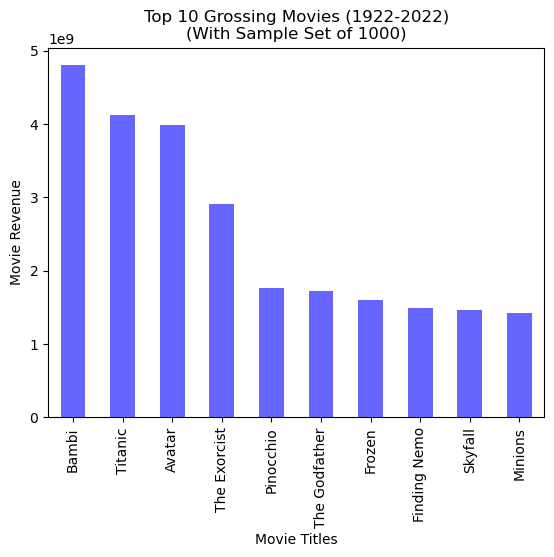

In [52]:
# Create a bar chart to display top 10 grossing movies

top_ten_df.plot("Title",
                "infl_adj_revenue",
                kind='bar',
                alpha=0.6,
                color='blue',
                title="Top 10 Grossing Movies (1922-2022)\n(With Sample Set of 1000)",
                xlabel="Movie Titles",
                ylabel="Movie Revenue",
                legend='')

# Export an image of this figure to the 'Output' folder
plt.savefig("Output/Top 10 Grossing Movies.png", bbox_inches='tight')

In [53]:
country_df = movie_list.copy(deep=True)
country_df[['country1', 'country2', 'country3', 'country4', 'country5', 'country6']] = country_df['production_countries'].str.split(', ', expand=True, n=5)
country_df.sample(10)

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,infl_adj_budget,infl_adj_revenue,real_profit,Decades,country1,country2,country3,country4,country5,country6
24,The Book of Life,2014,228326,tt2262227,"Animation, Adventure, Comedy, Family, Fantasy",95,50000000,97437106.0,United States of America,78.782,...,61810413.287375,120452555.827715,5.864214e+07,2010s,United States of America,None,None,None,None,None
493,Kick-Ass,2010,23483,tt1250777,"Action, Crime",117,28000000,96188903.0,"United Kingdom, United States of America",36.65,...,37579062.259236,129096027.660165,9.151697e+07,2000s,United Kingdom,United States of America,None,None,None,None
277,Finding Nemo,2003,12,tt0266543,"Animation, Family",100,94000000,940335536.0,United States of America,84.388,...,149508532.608696,1495619001.565652,1.346110e+09,2000s,United States of America,None,None,None,None,None
268,7Aum Arivu,2011,86718,tt1725795,"Action, Science Fiction, Thriller",168,16000000,98900000.0,India,4.23,...,20816665.851631,128673015.795393,1.078563e+08,2010s,India,None,None,None,None,None
852,"New York, I Love You",2008,12572,tt0808399,"Comedy, Drama, Romance",103,14700000,14603177.0,United States of America,13.871,...,19981275.226077,19849666.585858,-1.316086e+05,2000s,United States of America,None,None,None,None,None
860,Dracula Untold,2014,49017,tt0829150,"Horror, Action, Fantasy",92,70000000,217124280.0,United States of America,31.444,...,86534578.602325,268410829.630474,1.818763e+08,2010s,United States of America,None,None,None,None,None
239,The Bad News Bears,1976,23479,tt0074174,"Family, Comedy",102,9000000,42349782.0,United States of America,10.59,...,46289894.551845,217818549.230404,1.715287e+08,1970s,United States of America,None,None,None,None,None
465,Edge of Tomorrow,2014,137113,tt1631867,"Action, Science Fiction",114,178000000,370541256.0,United States of America,53.779,...,220045071.303055,458066163.46766,2.380211e+08,2010s,United States of America,None,None,None,None,None
863,All About Steve,2009,23706,tt0881891,Comedy,99,15000000,40105542.0,United States of America,14.798,...,20461855.064628,54708919.179489,3.424706e+07,2000s,United States of America,None,None,None,None,None
713,Unfinished Business,2015,239573,tt2358925,Comedy,91,35000000,14431253.0,United States of America,15.182,...,43215992.945654,17818883.652713,-2.539711e+07,2010s,United States of America,None,None,None,None,None


# Data Visualization

## Top Production Countries

In [54]:
#sorting the movies by highest grossers
country_df2 = country_df.sort_values(by='infl_adj_revenue', ascending=False)
country_df3 = country_df2.iloc[0:50, :]
country_df3

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,infl_adj_budget,infl_adj_revenue,real_profit,Decades,country1,country2,country3,country4,country5,country6
802,Bambi,1942,3170,tt0034492,"Animation, Drama, Family",70,858000,267447150.0,United States of America,57.512,...,15404784.662577,4801824888.542945,4.786420e+09,1940s,United States of America,None,None,None,None,None
562,Titanic,1997,597,tt0120338,"Drama, Romance",194,200000000,2264162353.0,United States of America,133.844,...,364679127.725857,4128463759.608816,3.763785e+09,1990s,United States of America,None,None,None,None,None
554,Avatar,2009,19995,tt0499549,"Action, Adventure, Fantasy, Science Fiction",162,237000000,2923706026.0,"United States of America, United Kingdom",121.895,...,323297310.021115,3988296597.039345,3.664999e+09,2000s,United States of America,United Kingdom,None,None,None,None
291,The Exorcist,1973,9552,tt0070047,Horror,122,12000000,441405644.0,United States of America,231.878,...,79095945.945946,2909449746.504955,2.830354e+09,1970s,United States of America,None,None,None,None,None
763,Pinocchio,1940,10895,tt0032910,"Animation, Family",88,2600000,84300000.0,United States of America,50.571,...,54350214.285714,1762201178.571428,1.707851e+09,1930s,United States of America,None,None,None,None,None
36,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411.0,United States of America,122.863,...,42007894.736842,1715787332.803947,1.673779e+09,1970s,United States of America,None,None,None,None,None
760,Frozen,2013,109445,tt2294629,"Animation, Family, Adventure, Fantasy",102,150000000,1274219009.0,United States of America,95.609,...,188439282.786094,1600752774.455779,1.412313e+09,2010s,United States of America,None,None,None,None,None
277,Finding Nemo,2003,12,tt0266543,"Animation, Family",100,94000000,940335536.0,United States of America,84.388,...,149508532.608696,1495619001.565652,1.346110e+09,2000s,United States of America,None,None,None,None,None
765,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295.0,"United Kingdom, United States of America",49.578,...,254932620.190423,1456266003.633479,1.201333e+09,2010s,United Kingdom,United States of America,None,None,None,None
769,Minions,2015,211672,tt2293640,"Family, Animation, Adventure, Comedy",91,74000000,1156730962.0,United States of America,30.307,...,91370956.513668,1428265059.823177,1.336894e+09,2010s,United States of America,None,None,None,None,None


In [55]:
#Identifying unique list of production countries for the TOP 50 movies by revenue
countries = list(country_df3["country1"].unique())
countries

['United States of America',
 'United Kingdom',
 'Panama',
 'New Zealand',
 'Italy',
 'Czech Republic']

In [56]:
# Preparing data to be visualize
# Import dependencies needed for world map visualizations
import matplotlib.pyplot as plt
import hvplot.pandas
import geoviews
import geopandas 

# Load the world map GeoDataFrame
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Filter the GeoDataFrame to select the list of top 10 grossing films' production countries
country_data = []
for i in range(len(countries)):
    country_data.append(world[world['name'] == countries[i]])

# Print the USA GeoDataFrame
print(country_data)

[     pop_est      continent                      name iso_a3  gdp_md_est  \
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  ,       pop_est continent            name iso_a3  gdp_md_est  \
143  64769452    Europe  United Kingdom    GBR   2788000.0   

                                              geometry  
143  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...  ,     pop_est      continent    name iso_a3  gdp_md_est  \
33  3753142  North America  Panama    PAN     93120.0   

                                             geometry  
33  POLYGON ((-77.35336 8.67050, -77.47472 8.52429...  ,      pop_est continent         name iso_a3  gdp_md_est  \
136  4510327   Oceania  New Zealand    NZL    174800.0   

                                              geometry  
136  MULTIPOLYGON (((176.88582 -40.06598, 176.50802...  ,       pop_est continent   name iso_

/Users/anitakumar/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/anitakumar/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/anitakumar/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/anitakumar/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48:

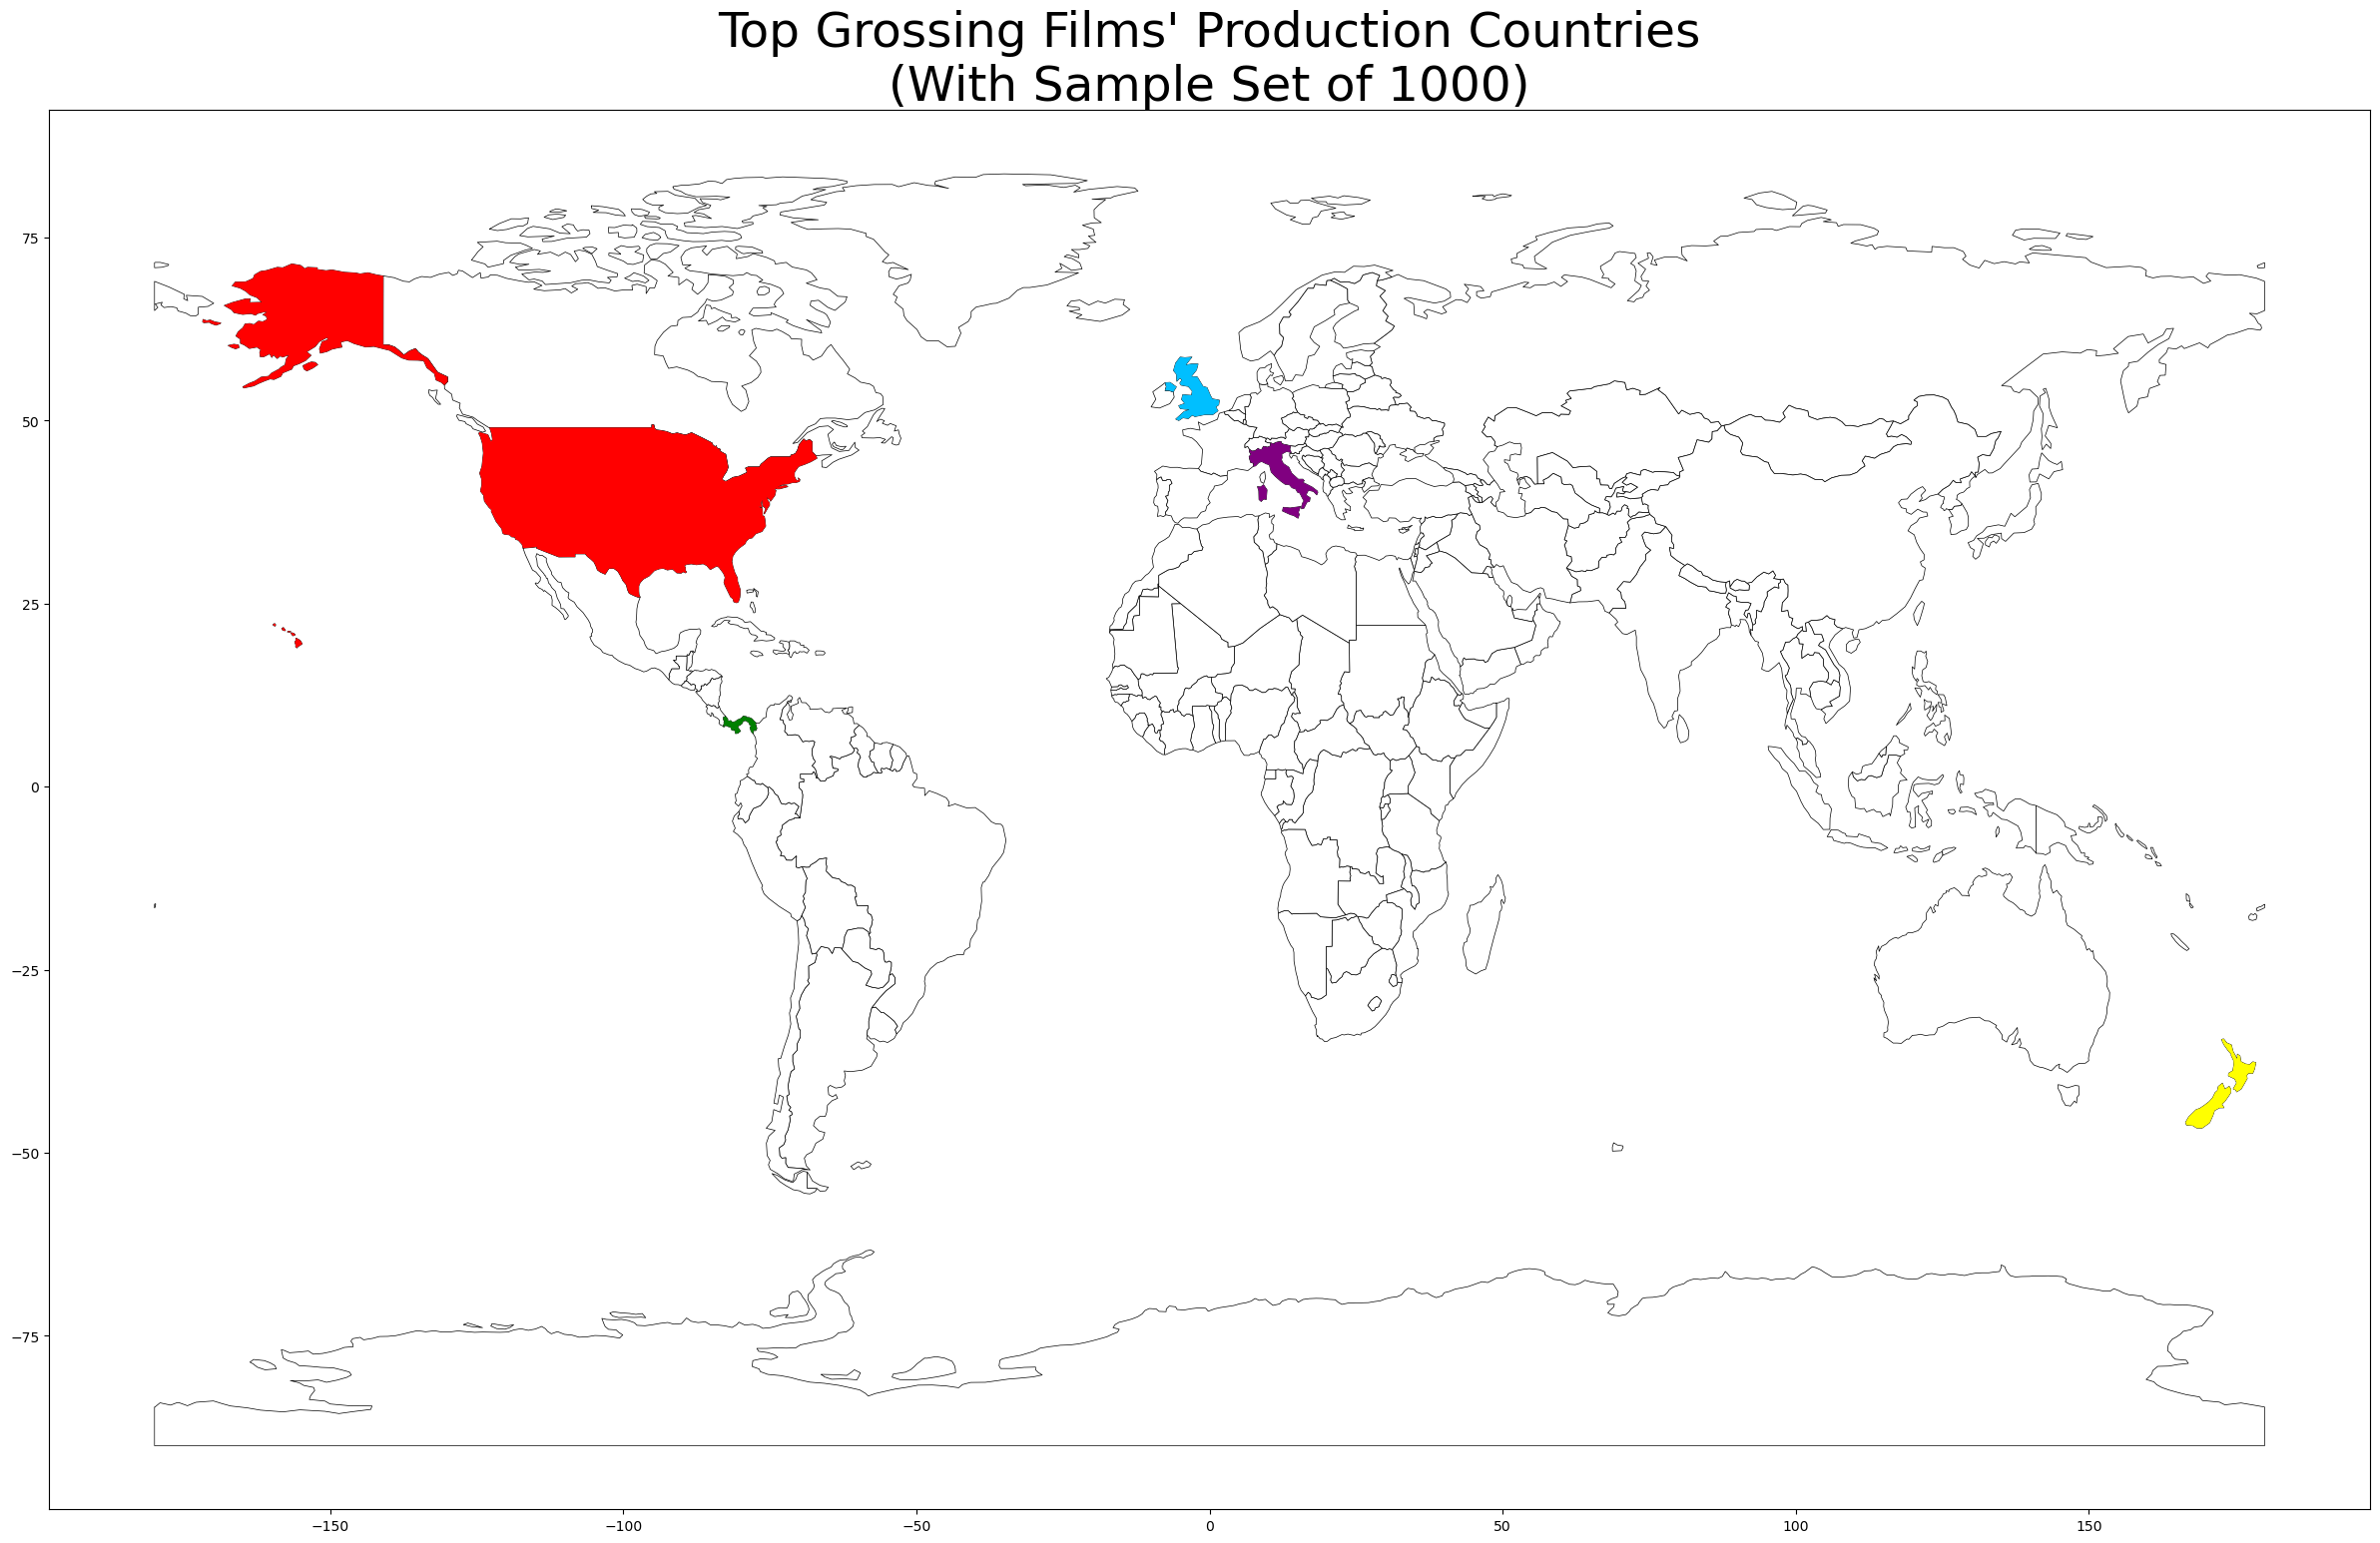

In [57]:
#Create visualization
# Create a base world map
world.plot(color='w', figsize=(30, 20), edgecolor='black', aspect="auto", linewidth=0.5)

# Create a list of colors to be looped through when plotting the list of countries
colors = ['red', 'deepskyblue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'peachpuff', 'gold', 
          'firebrick', 'darkturquoise', 'blueviolet', 'maroon']

for i in range(len(country_data)):
    current_color = colors[i % len(colors)] 
    country_data[i].plot(color=current_color, alpha=1, aspect='1.25', ax=plt.gca())

plt.title(f"Top Grossing Films' Production Countries\n(With Sample Set of 1000)", fontsize=35)

# Export an image of this figure to the 'Output' folder
plt.savefig("Output/Top Grossing Films Coutries.png", bbox_inches='tight')
plt.show()

### Production Country Analysis: 

Movies are most frequently produced in the six countries listed above. All of them may not be represented in the map above. This observation is representative of the sample data set from the initial movie list.

## Distribution of Movies Produced per Decade

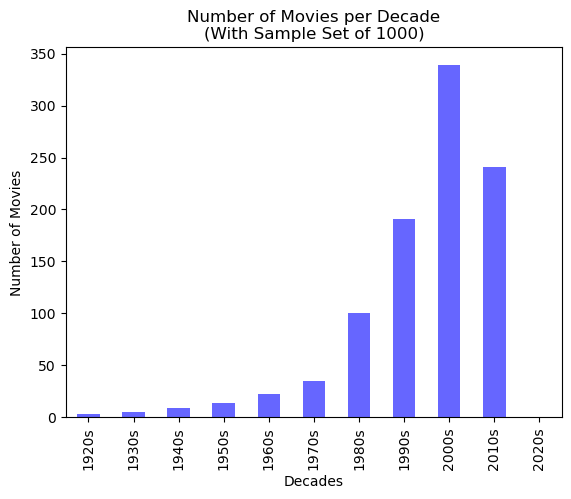

In [59]:
# Create a bar chart based upon the above data
y_axis=movie_list.groupby('Decades').count()['Title']
y_axis.plot(kind='bar',
            alpha=0.6,
            color='blue',
            title="Number of Movies per Decade\n(With Sample Set of 1000)",
            xlabel="Decades",
            ylabel="Number of Movies")
# Export an image of this figure to the 'Output' folder
plt.savefig("Output/Number of Movies per Decade.png", bbox_inches='tight')

### Movie Production Distribution Analysis:
Production of movies peaked in 2000s. It increased every year from 1920-2000.

## Number of Movies Produced based on varying budgets

In [107]:
#Categorizing budget into Low, Average, High

# Minimum Budget
min_budget = movie_list['infl_adj_budget'].min()
# Average Budget
avg_budget = movie_list['infl_adj_budget'].mean()
# Maximum Budget
max_budget = movie_list['infl_adj_budget'].max()

#Spliting the budget into three ranges 
diff = (max_budget-min_budget)/3

# Define the bins and labels
bins=[min_budget,round(min_budget+diff),round(min_budget+2*diff),round(min_budget+3*diff)]
labels = ['Low Budget', 'Average Budget', 'High Budget']
# Cut the 'Budget' column into categories and create a new column 'Budget_Category'
movie_list['Budget_Category'] = pd.cut(movie_list['infl_adj_budget'], bins=bins, labels=labels)
movie_list.sample(10)

[3528.650731641442, 121562062, 243120595, 364679128]


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category
24,The Book of Life,2014,228326,tt2262227,"Animation, Adventure, Comedy, Family, Fantasy",95,50000000,97437106.0,United States of America,78.782,7.537,7.2,"75,541",61810413.287375,120452555.827715,5.864214e+07,2010s,Low Budget
217,Lawrence of Arabia,1962,947,tt0056172,"Adventure, Drama, History, War",228,15000000,69995385.0,United Kingdom,29.648,7.979,8.3,"305,928",145358443.708609,678294682.025662,5.329362e+08,1960s,Average Budget
389,Madagascar,2005,953,tt0351283,"Family, Animation, Adventure, Comedy",86,75000000,542063846.0,United States of America,73.529,6.894,6.9,"425,143",112386712.749616,812276983.364721,6.998903e+08,2000s,Low Budget
236,Free Willy,1993,1634,tt0106965,"Family, Adventure, Drama",112,20000000,153698625.0,"France, United States of America",22.861,6.169,6.0,"81,039",40505882.352941,311284921.102941,2.707790e+08,1990s,Low Budget
151,Trapped,2002,9039,tt0280380,"Action, Crime, Thriller",106,30000000,13414416.0,"Germany, United States of America",12.748,6.189,6.1,"24,921",48802946.081156,21822100.69194,-2.698085e+07,2000s,Low Budget
427,Peggy Sue Got Married,1986,10013,tt0091738,"Comedy, Drama, Fantasy",103,18000000,41382841.0,United States of America,10.859,6.100,6.4,"39,758",48063777.372263,110500869.825319,6.243709e+07,1980s,Low Budget
689,Leprechaun,1993,11811,tt0107387,"Horror, Comedy, Fantasy",91,1000000,8556940.0,United States of America,23.007,5.572,4.8,"29,089",2025294.117647,17330320.247059,1.530503e+07,1990s,Low Budget
855,The Powerpuff Girls Movie,2002,59387,tt0289408,"Animation, Action, Family",74,11000000,16426471.0,"United Kingdom, United States of America",21.0,6.690,6.5,"10,751",17894413.563091,26722005.950556,8.827592e+06,2000s,Low Budget
536,Life or Something Like It,2002,16643,tt0282687,"Comedy, Drama, Romance",103,40000000,16872671.0,"Canada, United States of America",11.044,5.700,5.7,"27,582",65070594.774875,27447868.43527,-3.762273e+07,2000s,Low Budget
300,The Visit,2015,298312,tt3567288,"Horror, Mystery, Thriller",94,5000000,98450062.0,United States of America,28.628,6.321,6.2,"145,464",6173713.277951,121560490.996891,1.153868e+08,2010s,Low Budget


  Budget_Category  count
0      Low Budget    849
1  Average Budget     95
2     High Budget     14


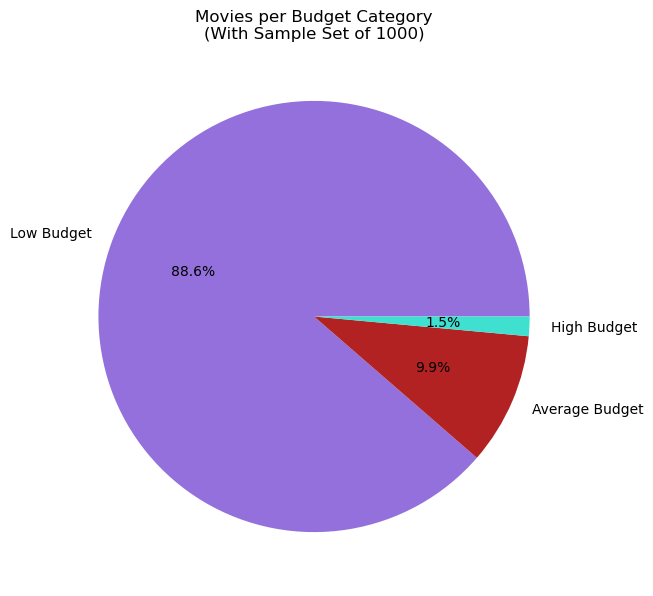

In [113]:
#Create visualization
# Pie plot showing the distribution of Budget category using pyplot
budget_distribution = movie_list['Budget_Category'].value_counts().reset_index()
print(budget_distribution)
#create y label
y = [budget_distribution['count'][0],budget_distribution['count'][1],budget_distribution['count'][2]]
#Show Pie Plot
plt.figure(figsize=(10,7))
plt.title("Movies per Budget Category\n(With Sample Set of 1000)")
plt.pie(y,autopct='%1.1f%%',
        labels=['Low Budget','Average Budget','High Budget'],
        colors=['mediumpurple', 'firebrick', 'turquoise'])

# Export an image of this figure to the 'Output' folder
plt.savefig("Output/Movies per Budget Category.png", bbox_inches='tight')
plt.show()

###  Analysis of Movies Produced per Budget Category
Over 80% movies observed in our sample set is made with a budget in the low budget category. 
Less that 10% movies observed in our sample set is made with a budget in the average budget category.
Less than 2% movies observed in our sample set is made with a budget in the high budget category.

## Movies per Budget Range by Decade

<Figure size 1000x200 with 0 Axes>

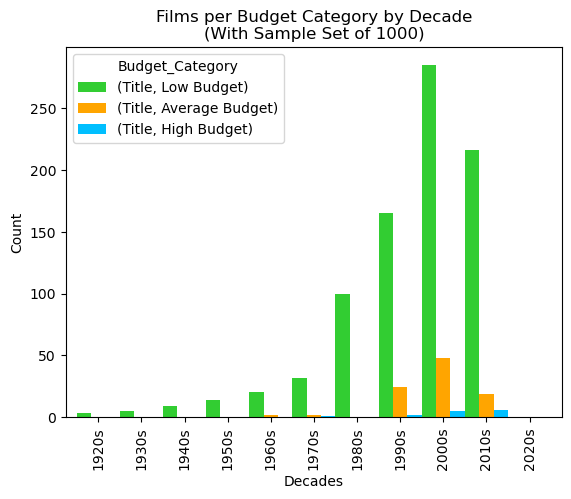

In [111]:
#Create Visualization
#Bar plot Budget Categories by Decades
grouped_df = movie_list.groupby(['Decades', 'Budget_Category'])['Title'].count().reset_index()
pivot_df=grouped_df.set_index(['Decades', 'Budget_Category'])
pivot_unstacked=pivot_df.unstack()
# Set the figure size
plt.figure(figsize=(10,2))  # Width, Height in inches
# Create a stacked bar plot
pivot_unstacked.plot(kind='bar',width=1,color=['limegreen', 'orange', 'deepskyblue'], stacked=False)
# Add labels and a title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('Films per Budget Category by Decade\n(With Sample Set of 1000)')
plt.legend(title='Budget_Category')

# Export an image of this figure to the 'Output' folder
plt.savefig("Output/Films per Budget Category by Decade.png", bbox_inches='tight')
#Show the plot
plt.show()

### Analysis of Movies per Budget Range by Decade
Production of movies peaked in 2000s. It increased every year from 1920-2009.

##  Number of Movies Produced based on their Primary Genre

In [62]:
#Preparing the data frame to study the genre

genre_df = movie_list.copy(deep=True)
# genre_df
genre_df[['primary_genre',
          'sub_genre_1',
          'sub_genre_2',
          'sub_genre_3',
          'sub_genre_4',
          'sub_genre_5']] = genre_df['genres'].str.split(', ', expand=True, n=5)
genre_df

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,infl_adj_revenue,real_profit,Decades,Budget_Category,primary_genre,sub_genre_1,sub_genre_2,sub_genre_3,sub_genre_4,sub_genre_5
0,The Valley of Decision,1945,43610,tt0038213,Drama,119,2160000,9132000.0,United States of America,3.55,...,148473636.666667,1.133550e+08,1940s,Low Budget,Drama,None,None,None,None,None
1,Half Nelson,2006,7859,tt0468489,Drama,107,700000,4911725.0,United States of America,10.128,...,7130163.094618,6.114000e+06,2000s,Low Budget,Drama,None,None,None,None,None
2,Fifty Shades of Grey,2015,216015,tt2322441,"Drama, Romance, Thriller",125,40000000,571006128.0,United States of America,116.138,...,705045622.844944,6.556559e+08,2010s,Low Budget,Drama,Romance,Thriller,None,None,None
3,Vanity Fair,2004,11632,tt0241025,"Drama, Romance",141,23000000,16123851.0,"United Kingdom, United States of America",11.299,...,24980019.13396,-1.065293e+07,2000s,Low Budget,Drama,Romance,None,None,None,None
4,We're the Millers,2013,138832,tt1723121,"Comedy, Crime",110,37000000,269994119.0,United States of America,36.081,...,339183320.938821,2.927016e+08,2010s,Low Budget,Comedy,Crime,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,Crimson Tide,1995,8963,tt0112740,"Thriller, Action",116,53000000,157387195.0,United States of America,21.784,...,302231952.445702,2.004556e+08,1990s,Low Budget,Thriller,Action,None,None,None,None
955,Big Momma's House,2000,9600,tt0208003,"Crime, Comedy",98,30000000,173959438.0,"Germany, United States of America",44.668,...,295645176.120151,2.446600e+08,1990s,Low Budget,Crime,Comedy,None,None,None,None
956,Safe Haven,2013,112949,tt1702439,"Romance, Thriller",115,28000000,97594140.0,United States of America,14.846,...,122603798.304837,8.742847e+07,2010s,Low Budget,Romance,Thriller,None,None,None,None
957,The Blob,1988,9599,tt0094761,"Horror, Science Fiction, Mystery",95,19000000,8247943.0,United States of America,25.085,...,20404072.347126,-2.659884e+07,1980s,Low Budget,Horror,Science Fiction,Mystery,None,None,None


In [63]:
# colors = plt.cm.Paired(range(len(primary_genre)))
primary_genre = genre_df['primary_genre'].value_counts()
primary_genre_length = len(primary_genre)

# Make blank list for explode values and loop through the primary genre length to append 0 after 0.1 accordingly
explode = []
for i in range(primary_genre_length):
    if i == 0:
        explode.append(0.1)
    else:
        explode.append(0)
print(f"Number of primary genres: {len(primary_genre)}")
primary_genre

Number of primary genres: 19


primary_genre
Drama              229
Comedy             213
Action             142
Horror              73
Adventure           65
Crime               48
Thriller            41
Animation           28
Science Fiction     24
Family              22
Romance             21
Fantasy             20
Mystery             13
Music                4
Western              4
History              4
War                  4
Documentary          3
TV Movie             1
Name: count, dtype: int64

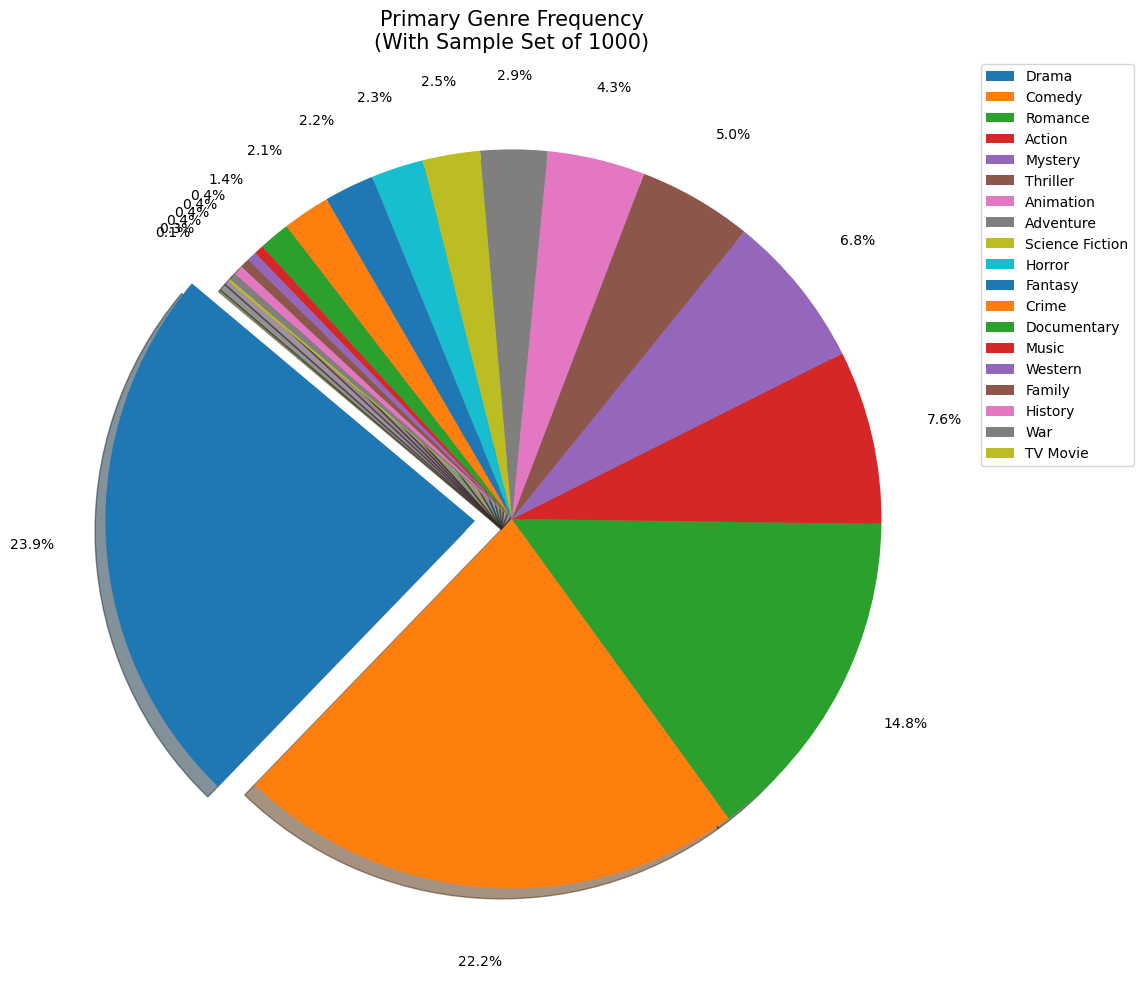

In [110]:
#Create visualization
plt.figure(figsize=(12, 12))
categories = genre_df['primary_genre'].unique()
# This code would be to include 'exploding' the biggest value out but has an error when 'explode' list is not equal
# to length of primary genres
plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2, explode=explode)
# plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2)
plt.legend(categories, loc='best', bbox_to_anchor=(1, 1))
plt.title('Primary Genre Frequency\n(With Sample Set of 1000)', fontsize=15)
plt.savefig("Output/Primary Genre Frequency.png", bbox_inches='tight')
plt.show()

### Analysis of Number of Movies Produced based on their Primary Genre
Data seems to vary largely every time a sample is pulled. 
The above pie chart displays the top three movies genres.

## Exploring the Distribution of Budget Data

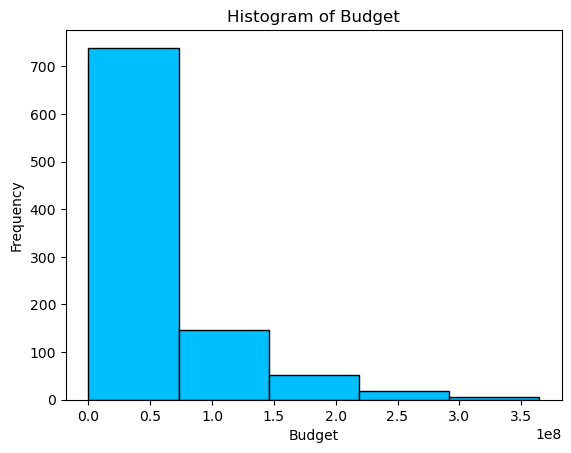

In [115]:
#Create Visualization
# Plot a histogram of budget
plt.hist(movie_list['infl_adj_budget'],bins=5, color='deepskyblue', edgecolor='k')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.title('Histogram of Budget')

# Export an image of this figure to the 'Output' folder 
plt.savefig("Output/Histogram of Budget.png",bbox_inches='tight')

In [116]:
#Null Hypothesis(H0): Budget data is normally distributed
from scipy.stats import shapiro
DataToTest = movie_list['infl_adj_budget']
stat,p = shapiro(DataToTest)
print(f"stat: {stat},p: {p}")
if(p>0.05):
    print("Accept NULL Hypothesis.") 
else:
    print("Reject NULL Hypothesis.") 

stat: 0.7833696007728577,p: 8.376050199986482e-34
Reject NULL Hypothesis.


### Analyzing the Distribution of Budget Data 
The budget data is not normally distributed.

# Scatter Plots with Linear Regression

In [129]:
# Creating a function for computing linear regression
def lin_regress(xval, yval, x_label, y_label,title): 
    x_values = xval
    y_values = yval
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values, c='blueviolet',s=6 )
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(10,20),fontsize=15,color="red")
    plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(slope, intercept)])
    print("The r-value is: ",rvalue)
    print(f"Slope: {slope}, Intercept: {intercept}")
    plt.show()

## Runtime of Movies over the Past Century

The r-value is:  -0.013258652784494888
Slope: -0.019056799804768678, Intercept: 148.10773951779242


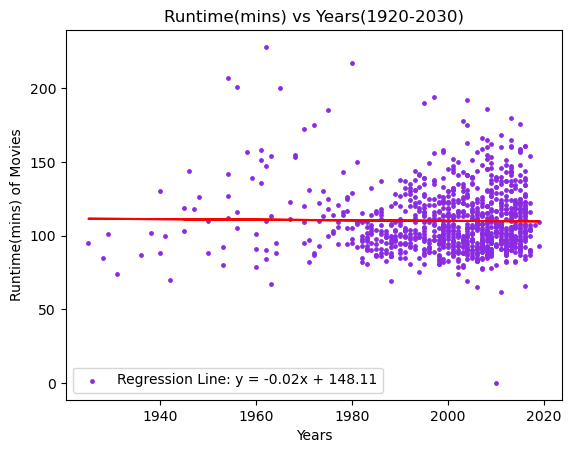

<Figure size 640x480 with 0 Axes>

In [140]:
#Create Visualization
# Create a scatter plot for regression analysis
xval = movie_list['Year']
yval = movie_list['runtime'].astype(int)
x_label='Years'
y_label='Runtime(mins) of Movies'
runtime_title="Runtime(mins) vs Years(1920-2030)"

lin_regress(xval, yval, x_label, y_label,runtime_title)
plt.savefig("Output/Runtime vs Years.png",bbox_inches='tight')

### Analyzing Runtime of Movies over the Past Century

There is a very weak negative relationship between the runtime and year of the movies.

The runtime of the movies has slightly reduced over the past century. 


## Budget vs TMDB Rating

The r-value is:  0.06320992354298074
Slope: 9.625049911496752e-10, Intercept: 6.450857285343395


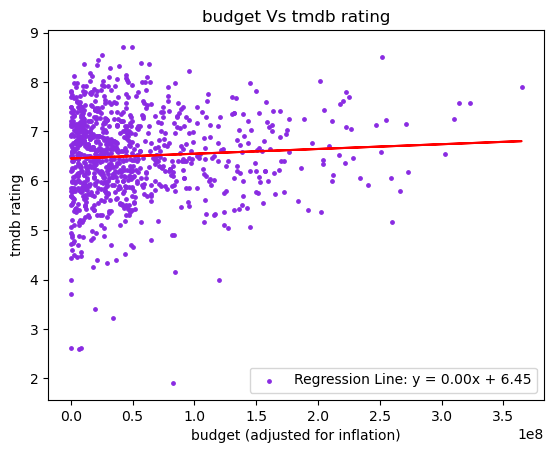

<Figure size 640x480 with 0 Axes>

In [141]:
# Create a scatter plot for regression analysis: Budget vs. tmdb

xval = movie_list['infl_adj_budget'].astype(int)
yval = movie_list['tmdb_rating'].astype(float)
x_label='budget (adjusted for inflation)'
y_label='tmdb rating'
budget_title="budget vs tmdb rating"

lin_regress(xval, yval, x_label, y_label,budget_title)
plt.savefig("Output/budget vs tmdb rating.png",bbox_inches='tight')

### Analyzing the correlation between budget and TMDB rating of movies
Based on above statistics, there is no correlation between the budget of movies and their TMDb ratings in this sample dataset.
This suggests that factors other than budget have a more substantial impact on a movie's TMDb rating.

##  Budget vs IMDB Rating

The r-value is:  0.04308927726909125
Slope: 7.890072379509572e-10, Intercept: 6.492565721242692


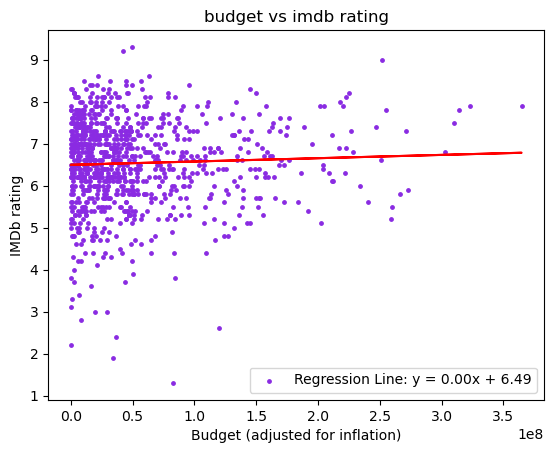

<Figure size 640x480 with 0 Axes>

In [147]:
#Create Visualization
# Create a scatter plot for regression analysis: Budget vs. imbd Rating

xval = movie_list['infl_adj_budget'].astype(int)
yval = movie_list['imdb_rating'].astype(float)
x_label='Budget (adjusted for inflation)'
y_label='IMDb rating'
rating_title="budget vs imdb rating"

lin_regress(xval, yval, x_label, y_label,rating_title)
plt.savefig("Output/budget vs imdb rating.png",bbox_inches='tight')

### Analyzing the correlation between budget and IMDb rating of movies
There is a weak relationship between the budget and IMDb rating of movies.
The overall trend in this sample dataset suggests that budget alone is not a strong predictor of IMDb ratings.

## Revenue vs IMDb Rating

The r-value is:  0.20361069235714668
Slope: 6.017987917660763e-10, Intercept: 6.427469186395021


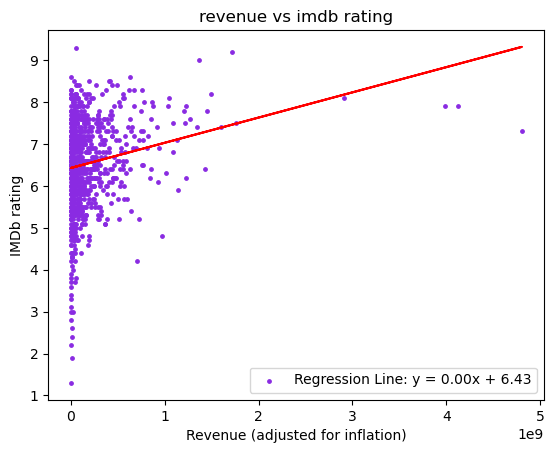

<Figure size 640x480 with 0 Axes>

In [146]:
#Create Visualization
# Create a scatter plot for regression analysis: Revenue vs. imbd Rating

xval = movie_list['infl_adj_revenue'].astype(float)
yval = movie_list['imdb_rating'].astype(float)
x_label='Revenue (adjusted for inflation)'
y_label='IMDb rating'
revenue_title="revenue vs imdb rating"
lin_regress(xval, yval, x_label, y_label,revenue_title)
plt.savefig("Output/revenue vs imdb rating.png",bbox_inches='tight')

### Analyzing the correlation between Revenue vs IMDb Rating
The positive correlation suggests that, on average, movies with higher revenue tend to have slightly higher IMDb ratings.

## Revenue vs. Runtime

The r-value is:  0.21547549523184287
Slope: 1.3474057381212e-08, Intercept: 107.6387988984897


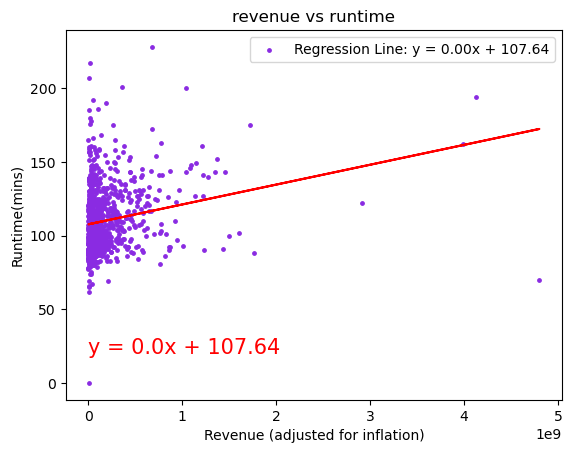

<Figure size 640x480 with 0 Axes>

In [145]:
# Create a scatter plot for regression analysis: Revenue vs. Runtime

xval = movie_list['infl_adj_revenue'].astype(float)
yval = movie_list['runtime'].astype(int)
x_label='Revenue (adjusted for inflation)'
y_label='Runtime(mins)'
revenue_title="revenue vs runtime"
lin_regress(xval, yval, x_label, y_label,revenue_title)
plt.savefig("Output/revenue vs runtime.png",bbox_inches='tight')

### Analyzing the correlation between Revenue vs Runtime
There is a weak positive corelation between runtime and revenue of movies. 
This suggests that,on average, longer movies tend to generate slightly higher revenue. 

# Data Testing

In [148]:
#TEST NULL HYPOTHESIS
#H0: There is a significant association between budget and revenue of a movie.
#H1: There is no significant association between budget and revenue of a movie
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(movie_list['infl_adj_budget'], movie_list['infl_adj_revenue'])

# Perform the chi-square test for independence
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)

alpha = 0.05  # Significance level

if p < alpha:
    print("Accept Null Hypothesis: There is no significant association between budget and revenue of a movie.")
else:
    print("Reject Null Hypothesis: There is no significant association between budget and revenue of a movie.")

Chi-Square Statistic: 768158.9999999995
P-value: 0.0006091965235673813
Accept Null Hypothesis: There is no significant association between budget and revenue of a movie.


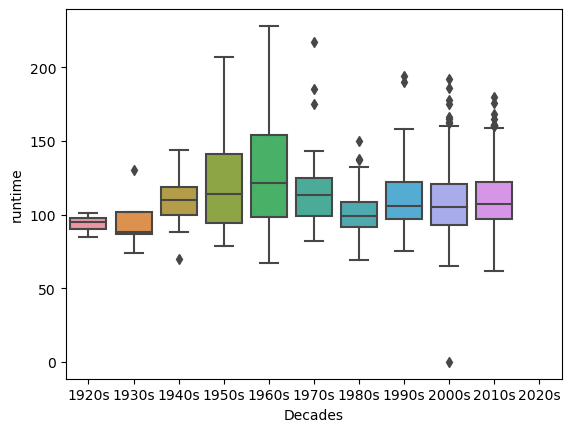

In [79]:
#Identifying Outliers in Movie Runtimes Over the Years
import seaborn as sns
ax = sns.boxplot(x='Decades',y='runtime',data=movie_list)

# Incorporating Oscar and Golden Globe Data

### Oscar dataset import and cleaning

In [80]:
# Import the Oscar csv to analyze
oscar_list = pd.read_csv("the_oscar_award.csv")
print(oscar_list.shape)
oscar_list.head(2)

(10765, 7)


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True


In [81]:
# Check for NaN values in the film column of the Oscar List
oscar_list["film"].isnull().value_counts()

film
False    10450
True       315
Name: count, dtype: int64

In [82]:
# Drop the NaN values and the "False" winners to clean the data
oscar_list.dropna(how="any", inplace=True)
oscar_winners = oscar_list["winner"]==True

oscars = oscar_list[oscar_winners]
print(oscars.shape)
oscars

(2149, 7)


,year_film,year_ceremony,ceremony,category,name,film,winner
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,True
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,True
10,1927,1928,1,CINEMATOGRAPHY,Karl Struss,Sunrise,True
...,...,...,...,...,...,...,...
10743,2022,2023,95,SOUND,"Mark Weingarten, James H. Mather, Al Nelson, C...",Top Gun: Maverick,True
10745,2022,2023,95,VISUAL EFFECTS,"Joe Letteri, Richard Baneham, Eric Saindon and...",Avatar: The Way of Water,True
10753,2022,2023,95,WRITING (Adapted Screenplay),Screenplay by Sarah Polley,Women Talking,True
10755,2022,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,Everything Everywhere All at Once,True


In [83]:
# Count the number of wins each film has and turn that series into a DataFrame
oscar_wins = oscars[["film", "year_film"]].value_counts()
oscar_win_df = oscar_wins.reset_index()
oscar_win_df

,film,year_film,count
0,Titanic,1997,11
1,Ben-Hur,1959,11
2,The Lord of the Rings: The Return of the King,2003,11
3,West Side Story,1961,10
4,The Last Emperor,1987,9
...,...,...,...
1325,Knighty Knight Bugs,1958,1
1326,Kokoda Front Line!,1942,1
1327,Kolya,1996,1
1328,Kon-Tiki,1951,1


In [84]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
oscar_win_df = oscar_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Oscar_Wins'})
oscar_win_df

,Title,Year,Oscar_Wins
0,Titanic,1997,11
1,Ben-Hur,1959,11
2,The Lord of the Rings: The Return of the King,2003,11
3,West Side Story,1961,10
4,The Last Emperor,1987,9
...,...,...,...
1325,Knighty Knight Bugs,1958,1
1326,Kokoda Front Line!,1942,1
1327,Kolya,1996,1
1328,Kon-Tiki,1951,1


### Golden Globe dataset import and cleaning

In [85]:
# Import the golden globes csv to analyze
gglobe_list = pd.read_csv("golden_globe_awards.csv")
print(gglobe_list.shape)
gglobe_list.head()

# gglobe_list

(7991, 7)


,year_film,year_award,ceremony,category,nominee,film,win
0,1943,1944,1,Best Performance by an Actress in a Supporting...,Katina Paxinou,For Whom The Bell Tolls,True
1,1943,1944,1,Best Performance by an Actor in a Supporting R...,Akim Tamiroff,For Whom The Bell Tolls,True
2,1943,1944,1,Best Director - Motion Picture,Henry King,The Song Of Bernadette,True
3,1943,1944,1,Picture,The Song Of Bernadette,NaN,True
4,1943,1944,1,Actress In A Leading Role,Jennifer Jones,The Song Of Bernadette,True


In [86]:
# Check for NaN values in the film column of the Golden Globe List
gglobe_list["film"].isnull().value_counts()

film
False    6191
True     1800
Name: count, dtype: int64

In [87]:
# Drop the NaN values and the "False" winners to clean the data
# gglobe_list.dropna(how="any", inplace=True)
gglobe_winners = gglobe_list["win"]==True
# gglobe_winners
gglobes = gglobe_list[gglobe_winners]

# Update the 'film' column where it is NaN with values from the 'nominee' column
gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])
gglobes.sample(10)

# print(gglobes.shape)
# gglobes

/var/folders/fp/vmh0_fl12wqbzwwbl65cz2yr0000gn/T/ipykernel_58294/1505913114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])


,year_film,year_award,ceremony,category,nominee,film,win
6148,2005,2006,63,Best Motion Picture - Foreign Language,Paradise Now,"Palestine, Hany Abu-Assad",True
560,1959,1960,17,Best Performance by an Actor in a Supporting R...,Stephen Boyd,Ben-Hur,True
6289,2006,2007,64,Best Television Series - Drama,Grey's Anatomy,Grey's Anatomy,True
3122,1981,1982,39,Best Television Limited Series or Motion Pictu...,Bill,Bill,True
200,1952,1953,10,Promoting International Understanding,George Seaton,Anything Can Happen,True
7984,2019,2020,77,Best Performance by an Actor in a Supporting R...,Stellan Skarsgård,Chernobyl,True
1426,1968,1969,26,Best Performance by an Actor in a Motion Pictu...,Peter O'Toole,The Lion in Winter,True
5706,2001,2002,59,Best Performance by an Actor in a Television S...,Charlie Sheen,Spin City,True
1345,1967,1968,25,Best Director - Motion Picture,Mike Nichols,"Graduate, The",True
6443,2007,2008,65,Best Performance by an Actress In A Television...,Glenn Close,Damages,True


In [88]:
# Count the number of wins each film has and turn that series into a DataFrame
gglobe_count = gglobes[["film", "year_film"]].value_counts()
gglobe_win_df = gglobe_count.reset_index()
gglobe_win_df

,film,year_film,count
0,La La Land,2016,7
1,Lawrence Of Arabia,1962,6
2,One Flew Over The Cuckoo's Nest,1975,6
3,Midnight Express,1978,6
4,Ordinary People,1980,5
...,...,...,...
1324,House,2006,1
1325,House of Cards,2013,1
1326,House of Cards,2014,1
1327,House of Lies,2012,1


In [89]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
gglobe_win_df = gglobe_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Golden_Globe_Wins'})
gglobe_win_df

,Title,Year,Golden_Globe_Wins
0,La La Land,2016,7
1,Lawrence Of Arabia,1962,6
2,One Flew Over The Cuckoo's Nest,1975,6
3,Midnight Express,1978,6
4,Ordinary People,1980,5
...,...,...,...
1324,House,2006,1
1325,House of Cards,2013,1
1326,House of Cards,2014,1
1327,House of Lies,2012,1


## Merging the Oscars and Golden Globes DataFrames into the Movie List DataFrame

In [90]:
# Referencing the movie_list for ease of coding
print(movie_list.shape)
movie_list.head(1)

(959, 18)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category
0,The Valley of Decision,1945,43610,tt0038213,Drama,119,2160000,9132000.0,United States of America,3.55,7.6,7.3,"2,288",35118600.0,148473636.666667,1.133550e+08,1940s,Low Budget


In [91]:
# Individually merge the Oscars and Golden Globes DataFrames into the master movie list
oscar_awards = pd.merge(movie_list, oscar_win_df, how="inner", on=["Title", "Year"])
print(oscar_awards.shape)
oscar_awards.head()

(72, 19)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins
0,Rebecca,1940,223,tt0032976,"Mystery, Romance, Thriller, Drama",130,1288000,7592465.0,United States of America,18.659,7.910,8.1,"143,208",26924260.0,158712346.041071,1.317881e+08,1930s,Low Budget,2
1,The Buddy Holly Story,1978,24153,tt0077280,"Drama, Music",114,1200000,14363400.0,United States of America,7.907,7.100,7.2,"9,757",5386288.343558,64471178.328221,5.908489e+07,1970s,Low Budget,1
2,Kramer vs. Kramer,1979,12102,tt0079417,Drama,105,8000000,106260000.0,United States of America,16.906,7.556,7.8,"151,535",32248484.848485,428340500.0,3.960920e+08,1970s,Low Budget,5
3,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411.0,United States of America,122.863,8.709,9.2,"1,954,449",42007894.736842,1715787332.803947,1.673779e+09,1970s,Low Budget,3
4,Sing,2016,335797,tt3470600,"Animation, Comedy, Family, Music",108,75000000,634151679.0,United States of America,65.412,7.100,7.1,"183,641",91452020.149412,773259361.675889,6.818073e+08,2010s,Low Budget,1


In [92]:
gglobe_awards = pd.merge(movie_list, gglobe_win_df, how="inner", on=["Title", "Year"])
print(gglobe_awards.shape)
gglobe_awards.head()

(51, 19)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Golden_Globe_Wins
0,Kramer vs. Kramer,1979,12102,tt0079417,Drama,105,8000000,106260000.0,United States of America,16.906,7.556,7.8,"151,535",32248484.848485,428340500.0,3.960920e+08,1970s,Low Budget,4
1,Fences,2016,393457,tt2671706,Drama,139,24000000,64414761.0,"Canada, United States of America",22.521,6.875,7.2,"114,417",29264646.447812,78544800.278554,4.928015e+07,2010s,Low Budget,1
2,Gentleman's Agreement,1947,33667,tt0039416,"Drama, Romance",118,2000000,7800000.0,United States of America,9.636,6.979,7.2,"17,358",26247085.201794,102363632.286996,7.611655e+07,1940s,Low Budget,4
3,A Walk in the Clouds,1995,9560,tt0114887,"Drama, Romance",103,20000000,50012507.0,United States of America,23.71,7.251,6.7,"35,767",38406167.979003,96039437.244652,5.763327e+07,1990s,Low Budget,1
4,Boogie Nights,1997,4995,tt0118749,Drama,156,15000000,43101594.0,United States of America,20.097,7.640,7.9,"276,335",27350934.579439,78591258.51757,5.124032e+07,1990s,Low Budget,1


In [93]:
# Make a DataFrame merging Golden Globe Awards data onto the merged Oscar data to show only films with wins in both
both_awards = pd.merge(oscar_awards, gglobe_win_df, how="inner", on=["Title", "Year"])
print(both_awards.shape)
both_awards

(33, 20)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins
0,Kramer vs. Kramer,1979,12102,tt0079417,Drama,105,8000000,106260000.0,United States of America,16.906,7.556,7.8,"151,535",32248484.848485,428340500.0,3.960920e+08,1970s,Low Budget,5,4
1,Fences,2016,393457,tt2671706,Drama,139,24000000,64414761.0,"Canada, United States of America",22.521,6.875,7.2,"114,417",29264646.447812,78544800.278554,4.928015e+07,2010s,Low Budget,1,1
2,Gentleman's Agreement,1947,33667,tt0039416,"Drama, Romance",118,2000000,7800000.0,United States of America,9.636,6.979,7.2,"17,358",26247085.201794,102363632.286996,7.611655e+07,1940s,Low Budget,3,4
3,Misery,1990,1700,tt0100157,"Drama, Thriller",107,20000000,61276872.0,United States of America,24.522,7.756,7.8,"226,443",44782708.492731,137207214.806121,9.242451e+07,1980s,Low Budget,1,1
4,Crazy Heart,2009,25196,tt1263670,"Drama, Music, Romance",112,7000000,47405566.0,United States of America,11.239,6.909,7.2,"93,204",9548865.696826,64667054.716576,5.511819e+07,2000s,Low Budget,2,2
5,12 Years a Slave,2013,76203,tt2024544,"Drama, History",134,20000000,187000000.0,"United States of America, United Kingdom",27.77,7.945,8.1,"726,006",25125237.704812,234920972.539997,2.097957e+08,2010s,Low Budget,3,1
6,Philadelphia,1993,9800,tt0107818,Drama,126,26000000,206678440.0,United States of America,22.043,7.725,7.7,"252,493",52657647.058824,418584628.776471,3.659270e+08,1990s,Low Budget,2,2
7,Ghost,1990,251,tt0099653,"Fantasy, Drama, Thriller, Mystery, Romance",127,22000000,505000000.0,United States of America,45.842,7.206,7.1,"229,517",49260979.342005,1130763389.441469,1.081502e+09,1980s,Low Budget,2,1
8,The Artist,2011,74643,tt1655442,"Drama, Comedy, Romance",100,15000000,133432856.0,"Belgium, France",11.607,7.453,7.9,"246,324",19515624.235904,173601698.561299,1.540861e+08,2010s,Low Budget,5,3
9,Shakespeare in Love,1998,1934,tt0138097,"Romance, History, Comedy",123,25000000,289317794.0,"United Kingdom, United States of America",14.695,6.869,7.1,"231,176",44885736.196319,519449687.135399,4.745640e+08,1990s,Low Budget,7,3


In [94]:
# Sum the Oscar and Golden Globe Award wins into a new column called cumulative awards
both_awards['Cumulative_Awards'] = ''
for index,row in both_awards.iterrows():
    both_awards.loc[index, "Cumulative_Awards"] = both_awards.loc[index,'Oscar_Wins']+both_awards.loc[index,'Golden_Globe_Wins']

both_awards.sort_values(by='Cumulative_Awards',ascending = False,inplace=True)
both_awards.head()

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins,Cumulative_Awards
18,Titanic,1997,597,tt0120338,"Drama, Romance",194,200000000,2264162353.0,United States of America,133.844,...,7.9,"1,248,724",364679127.725857,4128463759.608816,3.763785e+09,1990s,High Budget,11,4,15
16,West Side Story,1961,1725,tt0055614,"Crime, Drama, Romance",151,6000000,43656822.0,United States of America,16.203,...,7.6,"118,794",58726755.852843,427303921.150836,3.685772e+08,1960s,Low Budget,10,3,13
10,Slumdog Millionaire,2008,12405,tt1010048,"Drama, Romance",120,15000000,378410542.0,United Kingdom,30.367,...,8.0,"866,174",20389056.35314,514362257.697338,4.939732e+08,2000s,Low Budget,8,4,12
9,Shakespeare in Love,1998,1934,tt0138097,"Romance, History, Comedy",123,25000000,289317794.0,"United Kingdom, United States of America",14.695,...,7.1,"231,176",44885736.196319,519449687.135399,4.745640e+08,1990s,Low Budget,7,3,10
13,Doctor Zhivago,1965,907,tt0059113,"Drama, Romance, War",200,11000000,111858363.0,"Italy, United Kingdom, United States of America",24.544,...,7.9,"80,383",102196984.126984,1039235213.452857,9.370382e+08,1960s,Low Budget,5,5,10


In [95]:
# Sort the data descending and grab the top 20 cumulative winners to do visualizations with
top20_both_awards = both_awards.sort_values(by='Cumulative_Awards', ascending=False)
top20_movies = top20_both_awards.iloc[0:20, :] 
top20_movies.head()

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,...,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins,Cumulative_Awards
18,Titanic,1997,597,tt0120338,"Drama, Romance",194,200000000,2264162353.0,United States of America,133.844,...,7.9,"1,248,724",364679127.725857,4128463759.608816,3.763785e+09,1990s,High Budget,11,4,15
16,West Side Story,1961,1725,tt0055614,"Crime, Drama, Romance",151,6000000,43656822.0,United States of America,16.203,...,7.6,"118,794",58726755.852843,427303921.150836,3.685772e+08,1960s,Low Budget,10,3,13
10,Slumdog Millionaire,2008,12405,tt1010048,"Drama, Romance",120,15000000,378410542.0,United Kingdom,30.367,...,8.0,"866,174",20389056.35314,514362257.697338,4.939732e+08,2000s,Low Budget,8,4,12
9,Shakespeare in Love,1998,1934,tt0138097,"Romance, History, Comedy",123,25000000,289317794.0,"United Kingdom, United States of America",14.695,...,7.1,"231,176",44885736.196319,519449687.135399,4.745640e+08,1990s,Low Budget,7,3,10
13,Doctor Zhivago,1965,907,tt0059113,"Drama, Romance, War",200,11000000,111858363.0,"Italy, United Kingdom, United States of America",24.544,...,7.9,"80,383",102196984.126984,1039235213.452857,9.370382e+08,1960s,Low Budget,5,5,10


## Top 20 movies with total Oscar & Golden Globe wins

<BarContainer object of 20 artists>

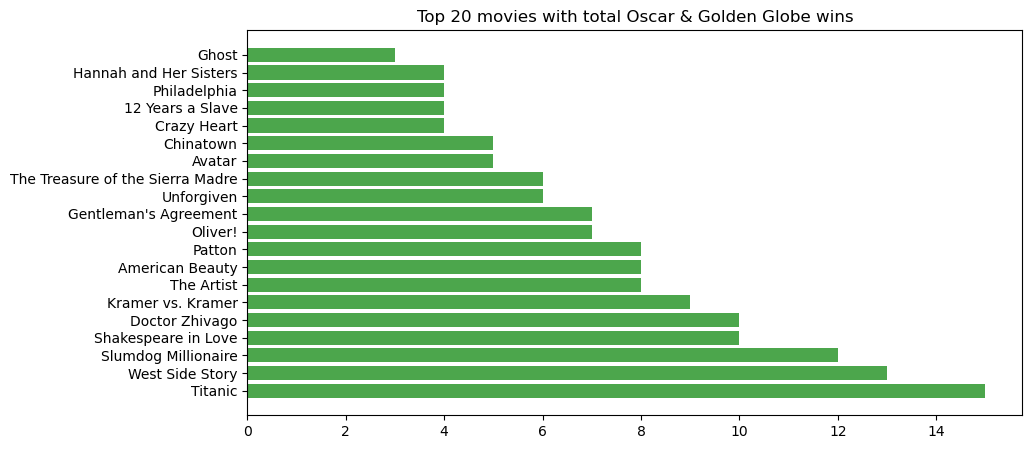

In [96]:
#Create Visualization
# plt.barh(x, y)
x=top20_movies['Title']
y=top20_movies['Cumulative_Awards']
plt.figure(figsize=(10,5))
plt.title('Top 20 movies with total Oscar & Golden Globe wins')
plt.barh(x,y,color='green',alpha=0.7)

In [97]:
# Take a look at how many awards were won by each decade
per_decade_wins=both_awards['Decades'].value_counts()
per_decade_wins

Decades
2000s    7
2010s    7
1990s    6
1960s    4
1970s    3
1980s    3
1940s    2
1950s    1
1920s    0
1930s    0
2020s    0
Name: count, dtype: int64

## Movies with Oscar and Golden Globe awards by Decade 

<BarContainer object of 11 artists>

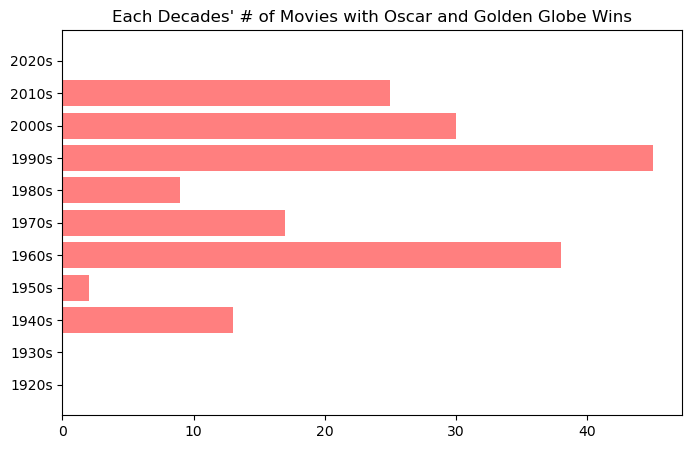

In [98]:
#Create Visualization
# Bar plot for cumulative Oscar and Golden Globe wins by Decade
decade_groupby = both_awards.groupby('Decades')
decades_sum=decade_groupby['Cumulative_Awards'].sum().reset_index()
decades_sum['Cumulative_Awards']
x=decades_sum['Decades']
y=decades_sum['Cumulative_Awards']
#plt.xlabel("Total oscar and golden globe wins")

plt.figure(figsize=(8,5))
plt.title(f"Number of Movies with Oscar and Golden Globe awards by Decade")
plt.barh(x,y,color='red',alpha=0.5)